# National Scaling Analysis

## Prepare

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import requests
import re

ModuleNotFoundError: No module named 'owid'

### Loading Data

In [4]:
base_variables = {
    "gdp_penn": "https://ourworldindata.org/grapher/national-gdp-penn-world-table.csv?v=1&csvType=full&useColumnShortNames=false",
    "prim_energy": "https://ourworldindata.org/grapher/primary-energy-cons.csv?v=1&csvType=full&useColumnShortNames=false",
    "population": "https://ourworldindata.org/grapher/population-with-un-projections.csv?v=1&csvType=full&useColumnShortNames=false",
    "urban_pop": "https://ourworldindata.org/grapher/urban-and-rural-population.csv?v=1&csvType=full&useColumnShortNames=false",
    "urban_pct": "https://ourworldindata.org/grapher/share-of-population-urban.csv?v=1&csvType=full&useColumnShortNames=false",
    "land_area": "https://ourworldindata.org/grapher/land-area-km.csv?v=1&csvType=full&useColumnShortNames=false",
}


In [5]:
"""
scaling_variables = {
    "electricity_gen": "https://ourworldindata.org/grapher/electricity-generation.csv?v=1&csvType=full&useColumnShortNames=false",
    "water_withdrawal": "https://ourworldindata.org/grapher/annual-freshwater-withdrawals.csv?v=1&csvType=full&useColumnShortNames=false",
    "muni_water_withdrawal": "https://ourworldindata.org/grapher/municipal-water-withdrawal.csv?v=1&csvType=full&useColumnShortNames=false",
    "new_patents": "https://ourworldindata.org/grapher/annual-patent-applications.csv?v=1&csvType=full&useColumnShortNames=false",
    "homicides": "https://ourworldindata.org/grapher/homicides-unodc.csv?v=1&csvType=full&useColumnShortNames=false",
    "hdi": "https://ourworldindata.org/grapher/human-development-index.csv?v=1&csvType=full&useColumnShortNames=false"
}
"""
# articles = pd.read_csv("https://ourworldindata.org/grapher/scientific-publications-per-million.csv?v=1&csvType=full&useColumnShortNames=false", storage_options={'User-Agent': 'Our World In Data data fetch/1.0'})

'\nscaling_variables = {\n    "electricity_gen": "https://ourworldindata.org/grapher/electricity-generation.csv?v=1&csvType=full&useColumnShortNames=false",\n    "water_withdrawal": "https://ourworldindata.org/grapher/annual-freshwater-withdrawals.csv?v=1&csvType=full&useColumnShortNames=false",\n    "muni_water_withdrawal": "https://ourworldindata.org/grapher/municipal-water-withdrawal.csv?v=1&csvType=full&useColumnShortNames=false",\n    "new_patents": "https://ourworldindata.org/grapher/annual-patent-applications.csv?v=1&csvType=full&useColumnShortNames=false",\n    "homicides": "https://ourworldindata.org/grapher/homicides-unodc.csv?v=1&csvType=full&useColumnShortNames=false",\n    "hdi": "https://ourworldindata.org/grapher/human-development-index.csv?v=1&csvType=full&useColumnShortNames=false"\n}\n'

In [15]:
def fetch_data(file_dict):
    """
    Fetch CSV files from a dictionary of links and create DataFrames with specified names.

    Args:
        file_dict (dict): Dictionary where keys are DataFrame names and values are CSV URLs.

    Returns:
        dict: Dictionary with specified keys as names and corresponding DataFrames as values.
    """
    dataframes = {}
    
    for name, url in file_dict.items():
        try:
            # Fetch the CSV and read it into a DataFrame
            dataframes[name] = pd.read_csv(
                url,
                storage_options={'User-Agent': 'Our World In Data data fetch/1.0'}
            )
            # Special logic to get rid of estimates
            # if name == "Population - Sex: all - Age: all - Variant: estimates":
            #    dataframes.drop(columns=["Population - Sex: all - Age: all - Variant: medium"], inplace=True)
        except Exception as e:
            print(f"Failed to fetch or parse {name} from {url}: {e}")
    
    return dataframes

In [16]:
# Creating dictionary of dataframes
base_dict = fetch_data(base_variables)

In [32]:
print(list(base_dict.keys()))

['gdp_penn', 'prim_energy', 'population', 'urban_pop', 'urban_pct', 'land_area']


In [17]:
# for value in dataframes.values():
    # print(value.info())

## Process

### Cleaning/Preprocessing

#### Merge datasets (except population)

##### Process
- Change Population data format to match the rest of the data
- Outer join on Entity and Year for dataset including regions
- Create iso_only dataset including only the entities that have an ISO code

##### Merged Dataset Description
- Excludes regional entities (no ISO codes)
- Excludes common entities with different names

In [18]:
def merge_dict_datasets(datasets, merge_on=['Entity', 'Code', 'Year'], join='inner'):
    """
    Merges a dictionary of pandas DataFrames on 'Entity' and 'Year' columns, ignoring the 'Code' column.
    
    Parameters:
    - datasets_to_merge: Dictionary of pandas DataFrame objects to be merged.
    - merge_on: List of columns to merge on (default is ['Entity', 'Code', 'Year'])
    - join: Type of join to use (default is 'outer').
    
    Returns:
    - merged_data: pandas DataFrame containing the merged data.
    """
    if not datasets:
        raise ValueError("The list of datasets to merge is empty.")

    # Convert to list
    datasets = list(datasets.values())
    
    # Start with the first dataset
    merged_data = datasets[0]
    
    # Merge datasets
    for df in datasets[1:]:
        merged_data = pd.merge(merged_data, df, on=merge_on, how=join)
    
    return merged_data


In [76]:
merged_base = merge_dict_datasets(base_dict, join='outer')
# merged_scaling = merge_dict_datasets(scaling_dict, join='outer')

In [77]:
merged_base.columns

Index(['Entity', 'Code', 'Year', 'GDP (output, multiple price benchmarks)',
       'Primary energy consumption (TWh)',
       'Population - Sex: all - Age: all - Variant: estimates',
       'Population - Sex: all - Age: all - Variant: medium',
       'Urban population', 'Rural population',
       'Urban population (% of total population)', 'Land area (sq. km)'],
      dtype='object')

In [78]:
merged_base.shape

(41281, 11)

In [79]:
# check(merged_base)
merged_base.drop(columns=["Population - Sex: all - Age: all - Variant: medium"], inplace=True)

In [80]:
merged_base.shape

(41281, 10)

In [52]:
def check(df):
    """ 
    Function to easily check the number of unique Entities and the percentage
    of nulls for each column
    """
    #Unique entities
    print(len(df.Entity.unique()))
    #Null percentages by column
    print(df.isnull().mean() * 100)

In [53]:
# for value in dataframes.values():
    # check(value)

#### Handling Missing Values
- Remove entities without ISO codes
- Select year range
- Remove entities with high null percentages
- Interpolate remainder if necessary
- Log transform columns

In [54]:
 def plot_null_percentages_over_time(columns, dataframe):
    """
    Plots the percentage of null values for the specified list of columns over time.

    Parameters:
    - columns (list): A list of column names to include in the plot.
    - dataframe (pd.DataFrame): The dataframe from which to calculate null percentages.

    Returns:
    - A matplotlib plot showing the percentage of null values for the respecified columns over time.
    """
    # Calculate the percentage of null values for each column by year
    null_percentage_by_year = dataframe.groupby('Year').apply(lambda x: x[columns].isnull().mean() * 100)

    # Plotting
    plt.figure(figsize=(15, 10))
    for column in null_percentage_by_year.columns:
        plt.plot(null_percentage_by_year.index, null_percentage_by_year[column], label=column)

    plt.title('Percentage of Null Values for Selected Columns Over Time')
    plt.xlabel('Year')
    plt.ylabel('Percentage of Null Values')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

In [55]:
def iso(df):
    return df[df['Code'].notna()]

def filter_years(df, start_year, end_year):
    return df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]

def overall_pct(df, threshold):
    """
    Returns a dataframe of entities with overall null percentages beneath the threshold

    Parameters:
    - df: DataFrame containing the data
    - threshold:

    """
    # Group by 'Entity' and calculate the percentage of missing values per entity
    entity_null_percentage = df.groupby('Entity').apply(lambda group: group.isnull().mean().mean() * 100)
    
    # Filter entities based on the threshold
    entities = entity_null_percentage[entity_null_percentage < threshold].index
    
    # Select rows that belong to the valid entities
    filtered_df = df[df['Entity'].isin(entities)]
    
    return filtered_df

def column_pct(df, threshold):
    # Group by 'Entity' and calculate the percentage of missing values per column for each entity
    entity_null_percentage = df.groupby('Entity').apply(lambda group: group.isnull().mean() * 100)
    
    # Select only entities where all columns have a null percentage below the threshold
    valid_entities = entity_null_percentage[entity_null_percentage.lt(threshold).all(axis=1)].index
    
    # Filter the dataframe to keep only the valid entities
    filtered_df = df[df['Entity'].isin(valid_entities)]
    
    return filtered_df


In [56]:
def interpolate_poly(df, order, columns):
    """
    Interpolates missing values in specified columns for each entity in the DataFrame
    with polynomial interpolation.

    Parameters:
    - df: DataFrame containing the data
    - columns_to_interpolate: List of column names to interpolate
    - method: Interpolation method (default is 'linear')

    Returns:
    - df: DataFrame with interpolated values
    """
    # Sort by 'Entity' and 'Year' to ensure time order within each entity
    df = df.sort_values(by=['Entity', 'Year'])

    # Apply interpolation for each column within each entity
    df[columns] = df.groupby('Entity')[columns].apply(
        lambda group: group.interpolate(method='polynomial', order=order)
    )
    
    return df


In [57]:
def log_transform_columns(df, columns, base=np.e):
    """
    Takes a dataframe and a list of column names to apply log transformation with a specified base.
    Returns a new dataframe with log-transformed specified columns.
    
    Args:
    df (pd.DataFrame): The original dataframe.
    columns (list): List of column names to apply the log transformation to.
    base (float): The base of the logarithm. Default is natural log (base e).
    
    Returns:
    pd.DataFrame: A new dataframe with the specified columns log-transformed.
    """
    # Copy the dataframe to avoid modifying the original
    df_transformed = df.copy()

    # Apply log transformation to the specified columns
    for col in columns:
        # Ensure no negative or zero values before applying log
        if (df_transformed[col] <= 0).any():
            raise ValueError(f"Column '{col}' contains zero or negative values, cannot apply log transform.")
        if base == np.e:
            df_transformed[col] = np.log(df_transformed[col])
        else:
            df_transformed[col] = np.log(df_transformed[col]) / np.log(base)  # Change of base formula

    return df_transformed


#### Base Variables

In [58]:
# Converting TWh to kWH to keep log transformed values positive
merged_base['Primary energy consumption (kWh)'] = merged_base['Primary energy consumption (TWh)'] * 10**9

In [59]:
# Calculating population density
merged_base['Population density'] = merged_base['Population - Sex: all - Age: all - Variant: estimates'] / merged_base['Land area (sq. km)']

In [60]:
merged_base.columns

Index(['Entity', 'Code', 'Year', 'GDP (output, multiple price benchmarks)',
       'Primary energy consumption (TWh)',
       'Population - Sex: all - Age: all - Variant: estimates',
       'Urban population', 'Rural population',
       'Urban population (% of total population)', 'Land area (sq. km)',
       'Primary energy consumption (kWh)', 'Population density'],
      dtype='object')

In [61]:
# Specify columns to log transform
base_vars_transform = [
    'GDP (output, multiple price benchmarks)',
    'Primary energy consumption (TWh)',
    'Primary energy consumption (kWh)',
    'Population - Sex: all - Age: all - Variant: estimates',
    'Urban population',
    'Population density'
]

In [62]:
df = (
    merged_base
    .pipe(iso)
    .pipe(filter_years, start_year=1990, end_year=2019) # Year Range
    .pipe(overall_pct, 0.8) # Entities by total nulls
    .pipe(column_pct, 0.2) # Entities by individual column null %
)
check(df)

140
Entity                                                   0.0
Code                                                     0.0
Year                                                     0.0
GDP (output, multiple price benchmarks)                  0.0
Primary energy consumption (TWh)                         0.0
Population - Sex: all - Age: all - Variant: estimates    0.0
Urban population                                         0.0
Rural population                                         0.0
Urban population (% of total population)                 0.0
Land area (sq. km)                                       0.0
Primary energy consumption (kWh)                         0.0
Population density                                       0.0
dtype: float64


In [63]:
world = df.groupby(['Year']).sum()

C:\Users\dunnn2\AppData\Local\Temp\ipykernel_45316\1838021077.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  world = df.groupby(['Year']).sum()


In [64]:
df = log_transform_columns(df, base_vars_transform)
world = log_transform_columns(world, base_vars_transform)
df.describe()

Year  GDP (output, multiple price benchmarks)  \
count  4200.000000                              4200.000000   
mean   2004.500000                                24.735653   
std       8.656472                                 2.248219   
min    1990.000000                                19.116269   
25%    1997.000000                                23.152750   
50%    2004.500000                                24.503263   
75%    2012.000000                                26.426549   
max    2019.000000                                30.656110   

       Primary energy consumption (TWh)  \
count                       4200.000000   
mean                           4.028979   
std                            2.498523   
min                           -1.641687   
25%                            2.144545   
50%                            3.910231   
75%                            5.903799   
max                           10.601337   

       Population - Sex: all - Age: all - Variant: estimates  \
count                                        4200.000000       
mean                                           15.690287       
std                                             2.052115       
min                                             9.660651       
25%                                            14.482671       
50%                                            15.930798       
75%                                            17.095429       
max                                            21.076399       

       Urban population  Rural population  \
count       4200.000000      4.200000e+03   
mean          14.986717      2.093985e+07   
std            2.102308      9.254683e+07   
min            8.689128      0.000000e+00   
25%           13.715181      5.923062e+05   
50%           15.165113      3.119932e+06   
75%           16.392666      1.136622e+07   
max           20.559550      9.102038e+08   

       Urban population (% of total population)  Land area (sq. km)  \
count                               4200.000000        4.200000e+03   
mean                                  55.536968        6.961086e+05   
std                                   23.585308        1.651321e+06   
min                                    5.416000        2.000000e+01   
25%                                   35.870500        2.542750e+04   
50%                                   55.169500        1.757700e+05   
75%                                   76.117250        5.673325e+05   
max                                  100.000000        9.388250e+06   

       Primary energy consumption (kWh)  Population density  
count                       4200.000000         4200.000000  
mean                          24.752245            4.242973  
std                            2.498523            1.604493  
min                           19.081579            0.335603  
25%                           22.867810            3.217206  
50%                           24.633497            4.299901  
75%                           26.627065            5.274375  
max                           31.324603            9.992583

In [69]:
df.columns

Index(['Entity', 'Code', 'Year', 'GDP (output, multiple price benchmarks)',
       'Primary energy consumption (TWh)',
       'Population - Sex: all - Age: all - Variant: estimates',
       'Urban population', 'Rural population',
       'Urban population (% of total population)', 'Land area (sq. km)',
       'Primary energy consumption (kWh)', 'Population density'],
      dtype='object')

In [73]:
df.describe()

Year  GDP (output, multiple price benchmarks)  \
count  4200.000000                              4200.000000   
mean   2004.500000                                24.735653   
std       8.656472                                 2.248219   
min    1990.000000                                19.116269   
25%    1997.000000                                23.152750   
50%    2004.500000                                24.503263   
75%    2012.000000                                26.426549   
max    2019.000000                                30.656110   

       Primary energy consumption (TWh)  \
count                       4200.000000   
mean                           4.028979   
std                            2.498523   
min                           -1.641687   
25%                            2.144545   
50%                            3.910231   
75%                            5.903799   
max                           10.601337   

       Population - Sex: all - Age: all - Variant: estimates  \
count                                        4200.000000       
mean                                           15.690287       
std                                             2.052115       
min                                             9.660651       
25%                                            14.482671       
50%                                            15.930798       
75%                                            17.095429       
max                                            21.076399       

       Urban population  Rural population  \
count       4200.000000      4.200000e+03   
mean          14.986717      2.093985e+07   
std            2.102308      9.254683e+07   
min            8.689128      0.000000e+00   
25%           13.715181      5.923062e+05   
50%           15.165113      3.119932e+06   
75%           16.392666      1.136622e+07   
max           20.559550      9.102038e+08   

       Urban population (% of total population)  Land area (sq. km)  \
count                               4200.000000        4.200000e+03   
mean                                  55.536968        6.961086e+05   
std                                   23.585308        1.651321e+06   
min                                    5.416000        2.000000e+01   
25%                                   35.870500        2.542750e+04   
50%                                   55.169500        1.757700e+05   
75%                                   76.117250        5.673325e+05   
max                                  100.000000        9.388250e+06   

       Primary energy consumption (kWh)  Population density  
count                       4200.000000         4200.000000  
mean                          24.752245            4.242973  
std                            2.498523            1.604493  
min                           19.081579            0.335603  
25%                           22.867810            3.217206  
50%                           24.633497            4.299901  
75%                           26.627065            5.274375  
max                           31.324603            9.992583

## Analysis Functions

In [65]:
from scipy import stats
import ipywidgets as widgets
from IPython.display import display

In [66]:
def scaling_analysis(log_x, log_y, x_label, y_label, title):
    """
    Perform linear regression on log-transformed data, create a scatter plot with the regression line,
    and display relevant statistics.
    
    Parameters:
    log_x (pd.Series): Log-transformed independent variable
    log_y (pd.Series): Log-transformed dependent variable
    x_label (str): Label for the x-axis of the plot
    y_label (str): Label for the y-axis of the plot
    title (str): Title for the plot
    
    Displays:
    - Slope (scaling exponent)
    - Intercept
    - R-squared value
    - P-value
    - Standard error of the slope
    - Normalization constant (Y_0)
    """
    # Perform linear regression on log-transformed data
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)
    
    # Calculate the normalization constant (Y_0)
    normalization_constant = np.exp(intercept)

    # Calculate Adjusted R-squared
    n = len(log_x)  # number of data points
    k = 1  # number of predictors
    r_squared = r_value ** 2
    adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
    
    # Create scatter plot with the regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(log_x, log_y, alpha=0.5)
    plt.plot(log_x, intercept + slope * log_x, color='red')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title=f"Slope = {slope:.2f}\nAdj. R² = {adjusted_r_squared:.2f}", loc='upper left')
    plt.grid(True)
    plt.show()
    
    # Display regression results
    print(f"Slope (Scaling Exponent, β): {slope:.4f}")
    print(f"Intercept (log(Y_0)): {intercept:.4f}")
    print(f"Normalization Constant (Y_0): {normalization_constant:.20f}")
    print(f"R-squared (Correlation Coefficient): {r_value**2:.4f}")
    print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
    print(f"P-value: {p_value:.4e}")
    print(f"Standard Error of the Slope: {std_err:.4f}")

In [67]:
def scaling_analysis_by_entity(data, log_x_col, log_y_col):
    """
    Perform linear regression for each entity, plot the distribution of beta values and adjusted R-squared values.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data
    log_x_col (str): Column name for the log-transformed independent variable
    log_y_col (str): Column name for the log-transformed dependent variable

    Displays:
    - Distribution of beta values (slopes)
    - Distribution of adjusted R-squared values
    """
    beta_values = []
    adjusted_r_squared_values = []

    for entity, group in data.groupby('Entity'):
        if len(group) > 1:  # Ensure there are enough data points for regression
            log_x = group[log_x_col]
            log_y = group[log_y_col]

            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_x, log_y)

            # Calculate Adjusted R-squared
            n = len(log_x)  # number of data points
            k = 1  # number of predictors
            r_squared = r_value ** 2
            adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))

            # Append results to lists
            beta_values.append(slope)
            adjusted_r_squared_values.append(adjusted_r_squared)

    # Plot distribution of beta values
    plt.figure(figsize=(10, 6))
    plt.hist(beta_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Beta Values (Slopes)')
    plt.xlabel('Beta Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Plot distribution of adjusted R-squared values
    plt.figure(figsize=(10, 6))
    plt.hist(adjusted_r_squared_values, bins=20, color='green', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Adjusted R-squared Values')
    plt.xlabel('Adjusted R-squared Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Display summary statistics
    print("Summary of Beta Values (Slopes):")
    print(pd.Series(beta_values).describe())
    print("\nSummary of Adjusted R-squared Values:")
    print(pd.Series(adjusted_r_squared_values).describe())

In [68]:
def plot_correlation_heatmap(df, target_col, col_list, corr_method='pearson'):
    """
    Plots a heatmap showing the correlation between a target column and a list of columns.
    
    Parameters:
    df: DataFrame
        The dataset containing the variables.
    target_col: str
        The name of the target column.
    col_list: list
        A list of column names to calculate correlation with the target column.
    corr_method: str
        The method to calculate correlation: 'pearson', 'spearman', or 'kendall'.
    """
    # Filter the dataframe to include only the target column and the columns from the list
    selected_columns = [target_col] + col_list
    df_selected = df[selected_columns]

    # Calculate the correlation matrix using the selected method
    corr_matrix = df_selected.corr(method=corr_method)

    # Extract only the correlations between the target column and the other columns
    target_corr = corr_matrix.loc[target_col, col_list].to_frame()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(target_corr, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
    
    # Add titles and labels
    plt.title(f'{corr_method.capitalize()} Correlation of {target_col} with Selected Columns', fontsize=14)
    plt.xlabel('Columns')
    plt.ylabel('Correlation with ' + target_col)
    
    # Display the heatmap
    plt.show()

## Analyze

#### 1. What is the relationship between energy and GDP?
Key Variables:
- GDP (output, multiple price benchmarks)
- Primary energy consumption (TWh)

Analysis:
- Scatterplot with Trendline
- Correlation Coefficient (Pearson and Spearman)
- Linear Regression

In [35]:
df.columns

Index(['Entity', 'Code', 'Year', 'GDP (output, multiple price benchmarks)',
       'Primary energy consumption (TWh)',
       'Population - Sex: all - Age: all - Variant: estimates',
       'Urban population', 'Rural population',
       'Urban population (% of total population)', 'Land area (sq. km)',
       'Primary energy consumption (kWh)', 'Population density'],
      dtype='object')

In [36]:
world.describe()

GDP (output, multiple price benchmarks)  \
count                                30.000000   
mean                                 31.856896   
std                                   0.349153   
min                                  31.282128   
25%                                  31.583307   
50%                                  31.850419   
75%                                  32.199725   
max                                  32.364870   

       Primary energy consumption (TWh)  \
count                         30.000000   
mean                          11.569043   
std                            0.212389   
min                           11.213647   
25%                           11.398726   
50%                           11.593695   
75%                           11.759141   
max                           11.884042   

       Population - Sex: all - Age: all - Variant: estimates  \
count                                          30.000000       
mean                                           22.465677       
std                                             0.114921       
min                                            22.262277       
25%                                            22.374227       
50%                                            22.470929       
75%                                            22.561477       
max                                            22.643546       

       Urban population  Rural population  \
count         30.000000      3.000000e+01   
mean          21.732468      2.931579e+09   
std            0.206723      9.030898e+07   
min           21.377839      2.712809e+09   
25%           21.563604      2.883949e+09   
50%           21.740689      2.969521e+09   
75%           21.906347      3.000551e+09   
max           22.054031      3.013380e+09   

       Urban population (% of total population)  Land area (sq. km)  \
count                                 30.000000        3.000000e+01   
mean                                7775.175567        9.745520e+07   
std                                  433.527592        1.769744e+04   
min                                 7067.719000        9.740800e+07   
25%                                 7411.187500        9.744353e+07   
50%                                 7768.222000        9.746298e+07   
75%                                 8139.193750        9.746646e+07   
max                                 8490.114000        9.747388e+07   

       Primary energy consumption (kWh)  Population density  
count                         30.000000           30.000000  
mean                          32.292309           10.866861  
std                            0.212389            0.091272  
min                           31.936913           10.692299  
25%                           32.121991           10.802461  
50%                           32.316961           10.856188  
75%                           32.482407           10.940560  
max                           32.607308           11.012773

In [37]:
world.columns

Index(['GDP (output, multiple price benchmarks)',
       'Primary energy consumption (TWh)',
       'Population - Sex: all - Age: all - Variant: estimates',
       'Urban population', 'Rural population',
       'Urban population (% of total population)', 'Land area (sq. km)',
       'Primary energy consumption (kWh)', 'Population density'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


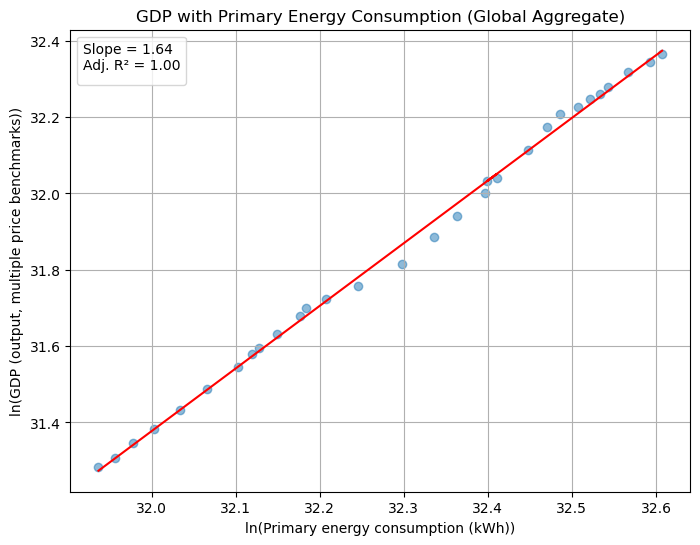

Slope (Scaling Exponent, β): 1.6415
Intercept (log(Y_0)): -21.1503
Normalization Constant (Y_0): 0.00000000065244352690
R-squared (Correlation Coefficient): 0.9970
Adjusted R-squared: 0.9969
P-value: 6.5491e-37
Standard Error of the Slope: 0.0170


In [38]:
# Relationship between primary energy consumption and GDP
scaling_analysis(world['Primary energy consumption (kWh)'], 
                 world['GDP (output, multiple price benchmarks)'],
                 x_label='ln(Primary energy consumption (kWh))',
                 y_label='ln(GDP (output, multiple price benchmarks))',
                 title='GDP with Primary Energy Consumption (Global Aggregate)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


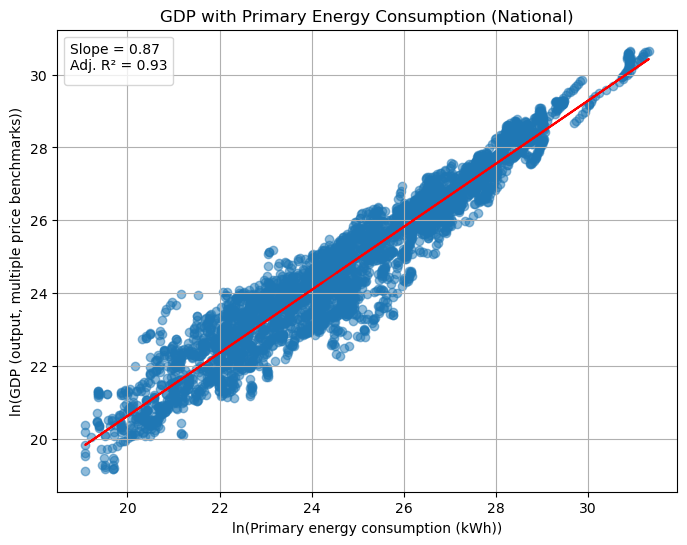

Slope (Scaling Exponent, β): 0.8661
Intercept (log(Y_0)): 3.2989
Normalization Constant (Y_0): 27.08302174511741711171
R-squared (Correlation Coefficient): 0.9264
Adjusted R-squared: 0.9263
P-value: 0.0000e+00
Standard Error of the Slope: 0.0038


In [39]:
# Relationship between primary energy consumption and GDP
scaling_analysis(df['Primary energy consumption (kWh)'], 
                 df['GDP (output, multiple price benchmarks)'],
                 x_label='ln(Primary energy consumption (kWh))',
                 y_label='ln(GDP (output, multiple price benchmarks))',
                 title='GDP with Primary Energy Consumption (National)')

In [40]:
df.columns

Index(['Entity', 'Code', 'Year', 'GDP (output, multiple price benchmarks)',
       'Primary energy consumption (TWh)',
       'Population - Sex: all - Age: all - Variant: estimates',
       'Urban population', 'Rural population',
       'Urban population (% of total population)', 'Land area (sq. km)',
       'Primary energy consumption (kWh)', 'Population density'],
      dtype='object')

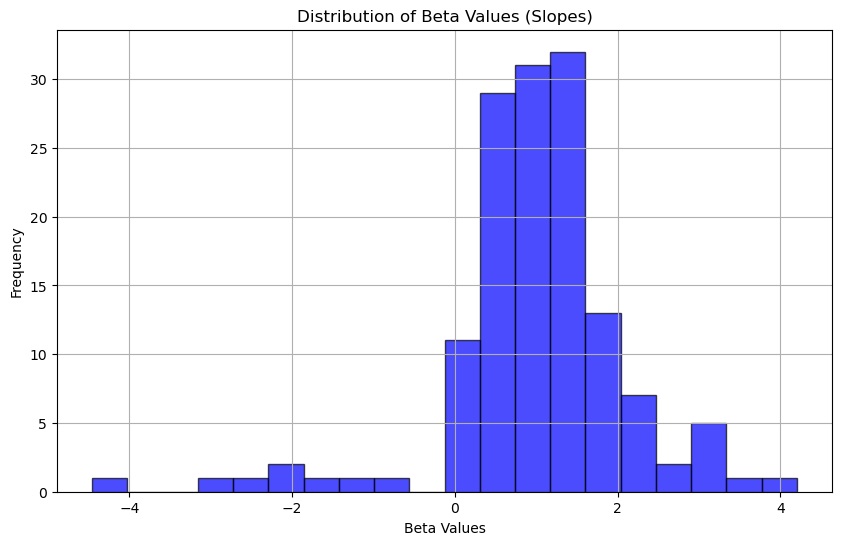

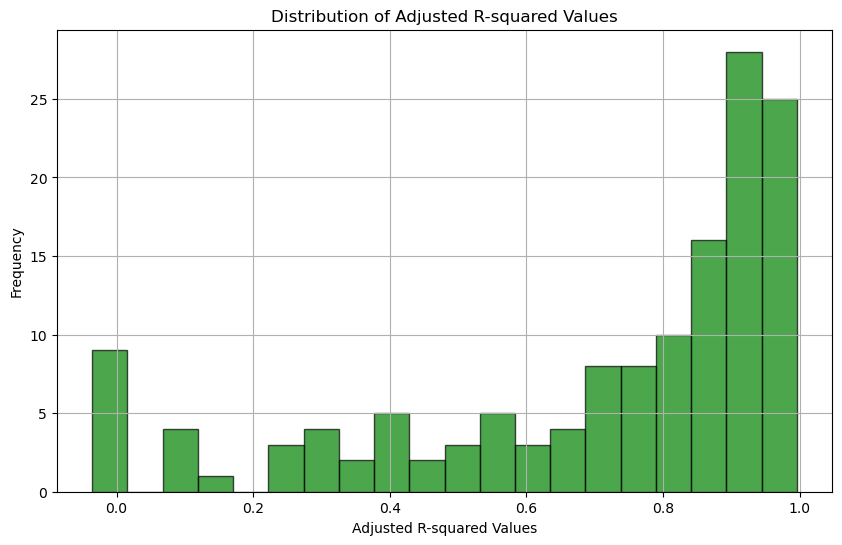

Summary of Beta Values (Slopes):
count    140.000000
mean       0.998961
std        1.118440
min       -4.455433
25%        0.599795
50%        1.060576
75%        1.436286
max        4.201776
dtype: float64

Summary of Adjusted R-squared Values:
count    140.000000
mean       0.700822
std        0.301657
min       -0.035629
25%        0.549735
50%        0.834626
75%        0.923127
max        0.995818
dtype: float64


In [41]:
# Distribution of scaling exponents and r^2 values
scaling_analysis_by_entity(df, 'Primary energy consumption (kWh)', 'GDP (output, multiple price benchmarks)')

#### 2: How does energy consumption relate to size and urbanization variables?

Key Variables:

- Population - Sex: all - Age: all - Variant: estimates
- Urban population (% of total population)
- Urban population
- Land area (sq. km)

Analysis:

- Pairwise Scatter Plots
- Correlation Analysis
- Multivariate Regression
- Interaction Terms

##### To-do:
- Multivariate Regression
- Interaction Terms

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


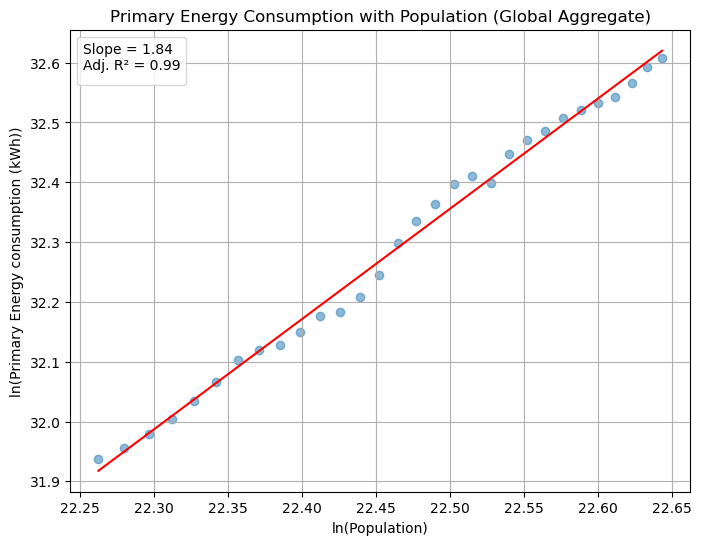

Slope (Scaling Exponent, β): 1.8412
Intercept (log(Y_0)): -9.0714
Normalization Constant (Y_0): 0.00011490427060020726
R-squared (Correlation Coefficient): 0.9925
Adjusted R-squared: 0.9922
P-value: 2.6438e-31
Standard Error of the Slope: 0.0302


In [42]:
scaling_analysis(world['Population - Sex: all - Age: all - Variant: estimates'],
                 world['Primary energy consumption (kWh)'],
                 x_label='ln(Population)',
                 y_label='ln(Primary Energy consumption (kWh))',
                 title='Primary Energy Consumption with Population (Global Aggregate)')

In [43]:
df.describe()

Year  GDP (output, multiple price benchmarks)  \
count  4200.000000                              4200.000000   
mean   2004.500000                                24.735653   
std       8.656472                                 2.248219   
min    1990.000000                                19.116269   
25%    1997.000000                                23.152750   
50%    2004.500000                                24.503263   
75%    2012.000000                                26.426549   
max    2019.000000                                30.656110   

       Primary energy consumption (TWh)  \
count                       4200.000000   
mean                           4.028979   
std                            2.498523   
min                           -1.641687   
25%                            2.144545   
50%                            3.910231   
75%                            5.903799   
max                           10.601337   

       Population - Sex: all - Age: all - Variant: estimates  \
count                                        4200.000000       
mean                                           15.690287       
std                                             2.052115       
min                                             9.660651       
25%                                            14.482671       
50%                                            15.930798       
75%                                            17.095429       
max                                            21.076399       

       Urban population  Rural population  \
count       4200.000000      4.200000e+03   
mean          14.986717      2.093985e+07   
std            2.102308      9.254683e+07   
min            8.689128      0.000000e+00   
25%           13.715181      5.923062e+05   
50%           15.165113      3.119932e+06   
75%           16.392666      1.136622e+07   
max           20.559550      9.102038e+08   

       Urban population (% of total population)  Land area (sq. km)  \
count                               4200.000000        4.200000e+03   
mean                                  55.536968        6.961086e+05   
std                                   23.585308        1.651321e+06   
min                                    5.416000        2.000000e+01   
25%                                   35.870500        2.542750e+04   
50%                                   55.169500        1.757700e+05   
75%                                   76.117250        5.673325e+05   
max                                  100.000000        9.388250e+06   

       Primary energy consumption (kWh)  Population density  
count                       4200.000000         4200.000000  
mean                          24.752245            4.242973  
std                            2.498523            1.604493  
min                           19.081579            0.335603  
25%                           22.867810            3.217206  
50%                           24.633497            4.299901  
75%                           26.627065            5.274375  
max                           31.324603            9.992583

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


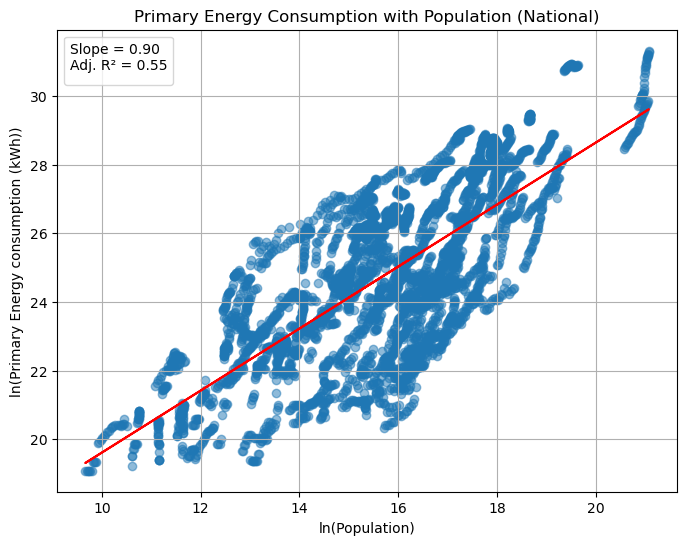

Slope (Scaling Exponent, β): 0.9033
Intercept (log(Y_0)): 10.5792
Normalization Constant (Y_0): 39307.24937905720435082912
R-squared (Correlation Coefficient): 0.5504
Adjusted R-squared: 0.5503
P-value: 0.0000e+00
Standard Error of the Slope: 0.0126


In [44]:
scaling_analysis(df['Population - Sex: all - Age: all - Variant: estimates'],
                 df['Primary energy consumption (kWh)'],
                 x_label='ln(Population)',
                 y_label='ln(Primary Energy consumption (kWh))',
                 title='Primary Energy Consumption with Population (National)')

In [45]:
df.describe()

Year  GDP (output, multiple price benchmarks)  \
count  4200.000000                              4200.000000   
mean   2004.500000                                24.735653   
std       8.656472                                 2.248219   
min    1990.000000                                19.116269   
25%    1997.000000                                23.152750   
50%    2004.500000                                24.503263   
75%    2012.000000                                26.426549   
max    2019.000000                                30.656110   

       Primary energy consumption (TWh)  \
count                       4200.000000   
mean                           4.028979   
std                            2.498523   
min                           -1.641687   
25%                            2.144545   
50%                            3.910231   
75%                            5.903799   
max                           10.601337   

       Population - Sex: all - Age: all - Variant: estimates  \
count                                        4200.000000       
mean                                           15.690287       
std                                             2.052115       
min                                             9.660651       
25%                                            14.482671       
50%                                            15.930798       
75%                                            17.095429       
max                                            21.076399       

       Urban population  Rural population  \
count       4200.000000      4.200000e+03   
mean          14.986717      2.093985e+07   
std            2.102308      9.254683e+07   
min            8.689128      0.000000e+00   
25%           13.715181      5.923062e+05   
50%           15.165113      3.119932e+06   
75%           16.392666      1.136622e+07   
max           20.559550      9.102038e+08   

       Urban population (% of total population)  Land area (sq. km)  \
count                               4200.000000        4.200000e+03   
mean                                  55.536968        6.961086e+05   
std                                   23.585308        1.651321e+06   
min                                    5.416000        2.000000e+01   
25%                                   35.870500        2.542750e+04   
50%                                   55.169500        1.757700e+05   
75%                                   76.117250        5.673325e+05   
max                                  100.000000        9.388250e+06   

       Primary energy consumption (kWh)  Population density  
count                       4200.000000         4200.000000  
mean                          24.752245            4.242973  
std                            2.498523            1.604493  
min                           19.081579            0.335603  
25%                           22.867810            3.217206  
50%                           24.633497            4.299901  
75%                           26.627065            5.274375  
max                           31.324603            9.992583

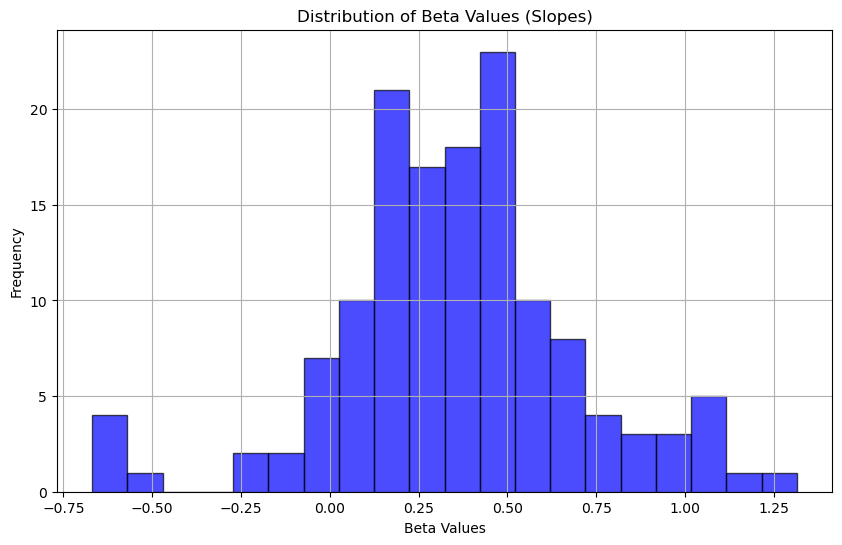

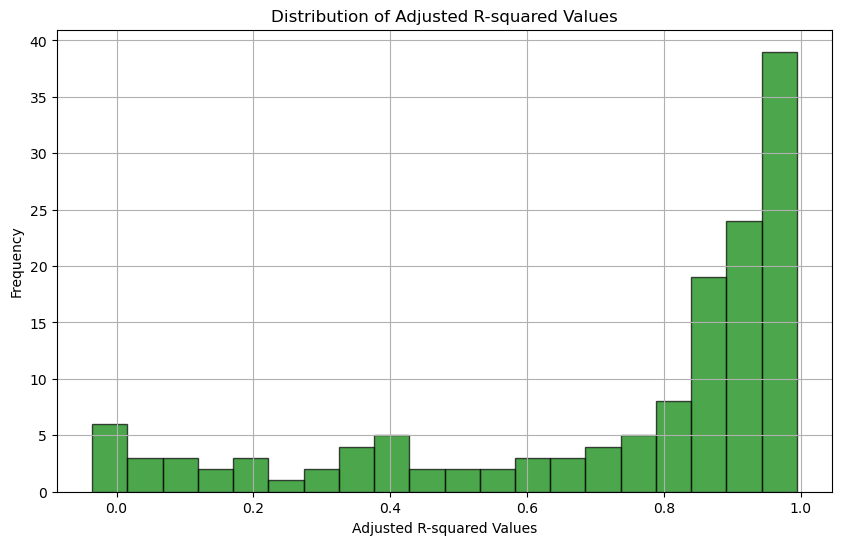

Summary of Beta Values (Slopes):
count    140.000000
mean       0.360716
std        0.345287
min       -0.668982
25%        0.164275
50%        0.345176
75%        0.521347
max        1.314978
dtype: float64

Summary of Adjusted R-squared Values:
count    140.000000
mean       0.726984
std        0.306172
min       -0.035544
25%        0.588895
50%        0.873330
75%        0.946789
max        0.993972
dtype: float64


In [46]:
# Distribution of betas and r^2 values for Primary Energy and Population
scaling_analysis_by_entity(df, 'Primary energy consumption (kWh)', 'Population - Sex: all - Age: all - Variant: estimates')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


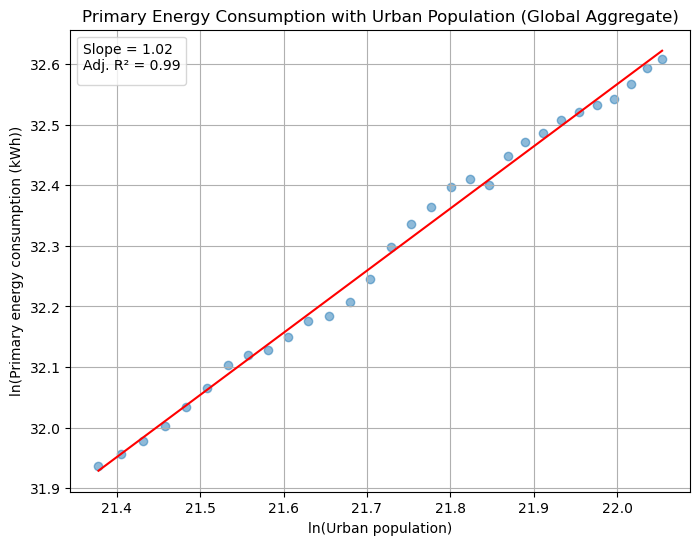

Slope (Scaling Exponent, β): 1.0243
Intercept (log(Y_0)): 10.0312
Normalization Constant (Y_0): 22724.40616358815168496221
R-squared (Correlation Coefficient): 0.9940
Adjusted R-squared: 0.9938
P-value: 1.1418e-32
Standard Error of the Slope: 0.0150


In [47]:
scaling_analysis(world['Urban population'],
                 world['Primary energy consumption (kWh)'],
                 x_label='ln(Urban population)',
                 y_label='ln(Primary energy consumption (kWh))',
                 title='Primary Energy Consumption with Urban Population (Global Aggregate)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


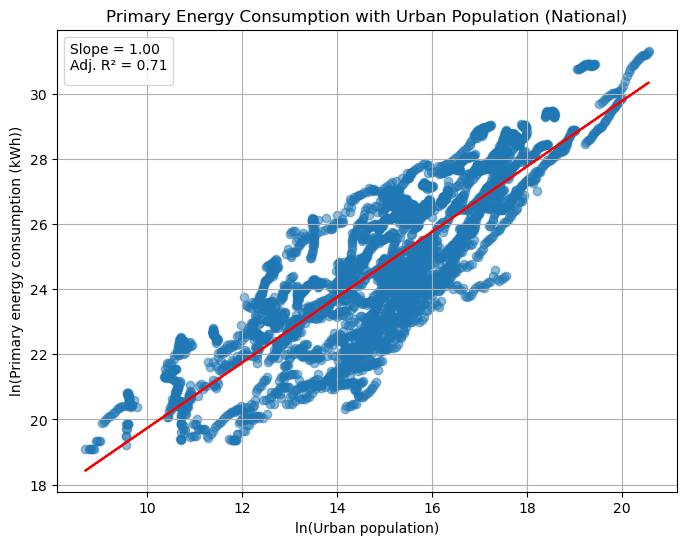

Slope (Scaling Exponent, β): 1.0045
Intercept (log(Y_0)): 9.6985
Normalization Constant (Y_0): 16292.58976390398493094835
R-squared (Correlation Coefficient): 0.7143
Adjusted R-squared: 0.7143
P-value: 0.0000e+00
Standard Error of the Slope: 0.0098


In [48]:
scaling_analysis(df['Urban population'],
                 df['Primary energy consumption (kWh)'],
                 x_label='ln(Urban population)',
                 y_label='ln(Primary energy consumption (kWh))',
                 title='Primary Energy Consumption with Urban Population (National)')

In [49]:
df.columns

Index(['Entity', 'Code', 'Year', 'GDP (output, multiple price benchmarks)',
       'Primary energy consumption (TWh)',
       'Population - Sex: all - Age: all - Variant: estimates',
       'Urban population', 'Rural population',
       'Urban population (% of total population)', 'Land area (sq. km)',
       'Primary energy consumption (kWh)', 'Population density'],
      dtype='object')

In [50]:
df.columns

Index(['Entity', 'Code', 'Year', 'GDP (output, multiple price benchmarks)',
       'Primary energy consumption (TWh)',
       'Population - Sex: all - Age: all - Variant: estimates',
       'Urban population', 'Rural population',
       'Urban population (% of total population)', 'Land area (sq. km)',
       'Primary energy consumption (kWh)', 'Population density'],
      dtype='object')

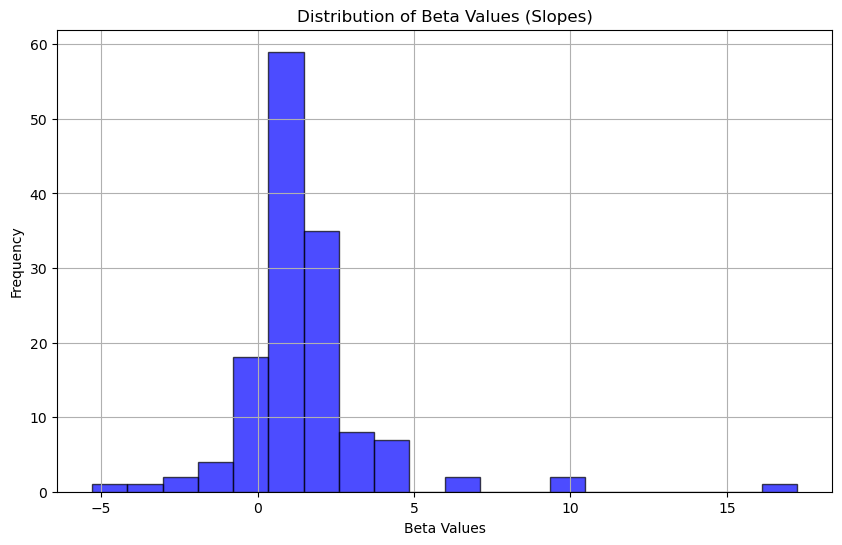

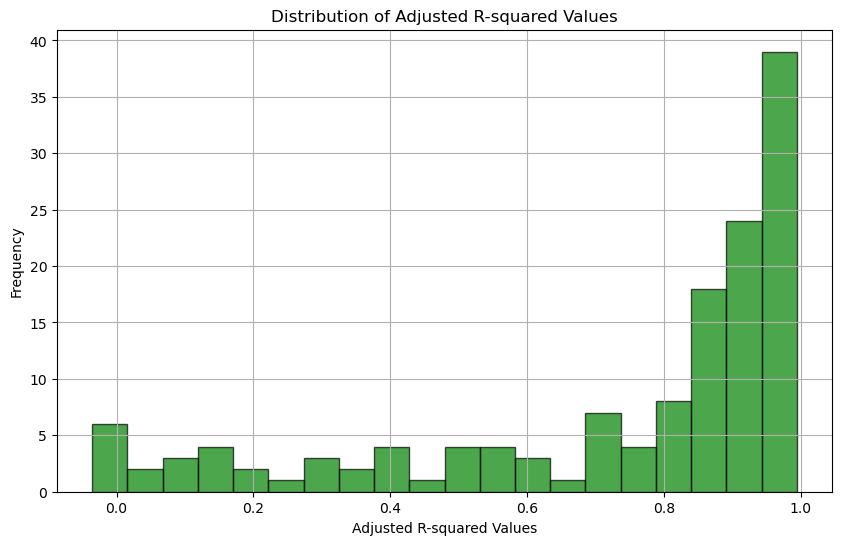

Summary of Beta Values (Slopes):
count    140.000000
mean       1.516671
std        2.281904
min       -5.286642
25%        0.699628
50%        1.210748
75%        1.934425
max       17.234996
dtype: float64

Summary of Adjusted R-squared Values:
count    140.000000
mean       0.727303
std        0.304595
min       -0.035479
25%        0.575362
50%        0.878168
75%        0.947154
max        0.994029
dtype: float64


In [51]:
# Distribution of betas and r^2 values for Energy and Urban Population
scaling_analysis_by_entity(df, 'Urban population', 'Primary energy consumption (kWh)')

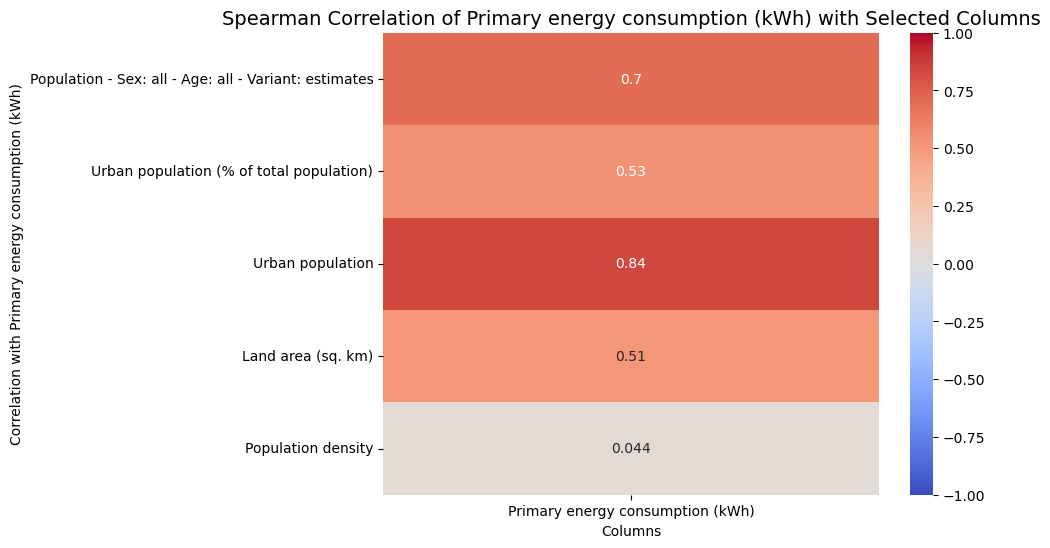

In [52]:
# Spearman Heatmap
plot_correlation_heatmap(df, 'Primary energy consumption (kWh)', 
                         ['Population - Sex: all - Age: all - Variant: estimates', 
                          'Urban population (% of total population)', 
                          'Urban population', 'Land area (sq. km)', 
                          'Population density'], 
                         corr_method='spearman')

#### 3: How does GDP relate to size and urbanization variables?

Key Variables:

- Population - Sex: all - Age: all - Variant: estimates
- Urban population (% of total population)
- Urban population
- Land area (sq. km)

Analysis:

- Pairwise Scatter Plots
- Correlation Analysis
- Multivariate Regression
- Interaction Terms

##### To-do:
- Multivariate Regression
- Interaction Terms

##### Correlation Analysis

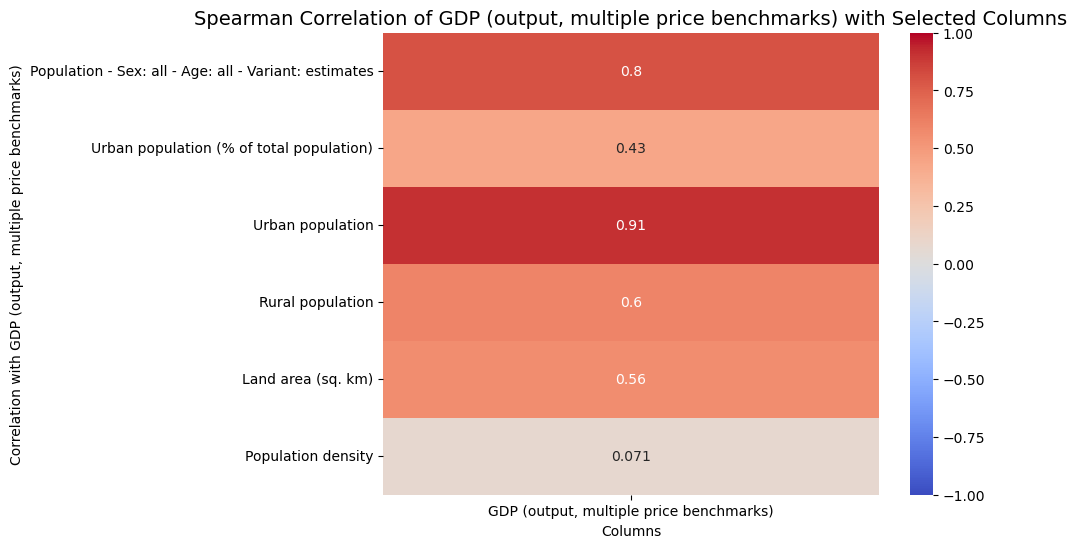

In [53]:
# Spearman Correlation Heatmap
plot_correlation_heatmap(df, 'GDP (output, multiple price benchmarks)', 
                         ['Population - Sex: all - Age: all - Variant: estimates', 'Urban population (% of total population)', 'Urban population', 'Rural population', 'Land area (sq. km)', 'Population density'], 
                         corr_method='spearman')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


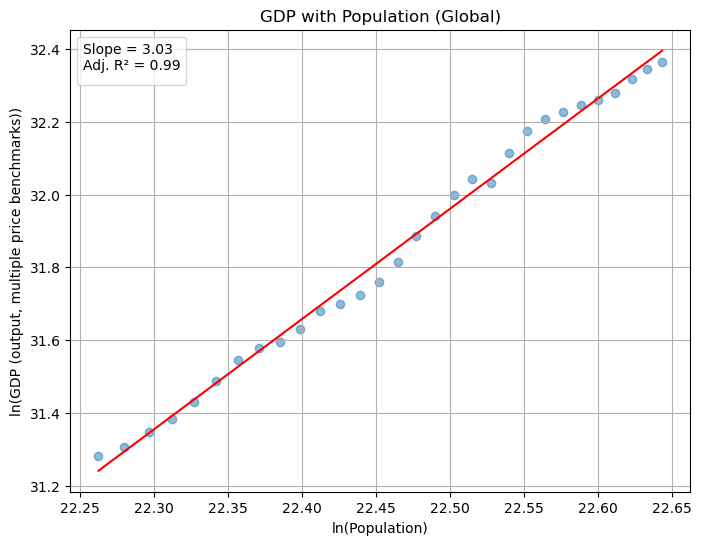

Slope (Scaling Exponent, β): 3.0274
Intercept (log(Y_0)): -36.1546
Normalization Constant (Y_0): 0.00000000000000019873
R-squared (Correlation Coefficient): 0.9929
Adjusted R-squared: 0.9926
P-value: 1.3272e-31
Standard Error of the Slope: 0.0485


In [54]:
scaling_analysis(world['Population - Sex: all - Age: all - Variant: estimates'], 
                 world['GDP (output, multiple price benchmarks)'],
                 x_label='ln(Population)',
                 y_label='ln(GDP (output, multiple price benchmarks))',
                 title='GDP with Population (Global)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


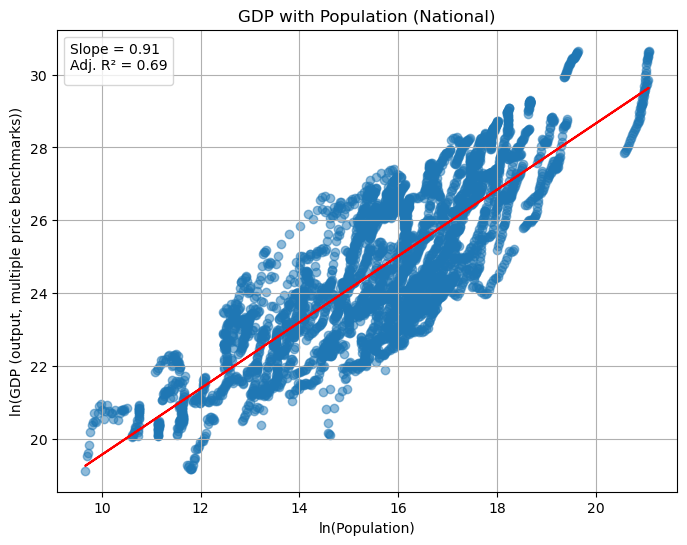

Slope (Scaling Exponent, β): 0.9097
Intercept (log(Y_0)): 10.4616
Normalization Constant (Y_0): 34948.04432593589444877580
R-squared (Correlation Coefficient): 0.6895
Adjusted R-squared: 0.6895
P-value: 0.0000e+00
Standard Error of the Slope: 0.0094


In [55]:
scaling_analysis(df['Population - Sex: all - Age: all - Variant: estimates'], 
                 df['GDP (output, multiple price benchmarks)'],
                 x_label='ln(Population)',
                 y_label='ln(GDP (output, multiple price benchmarks))',
                 title='GDP with Population (National)')

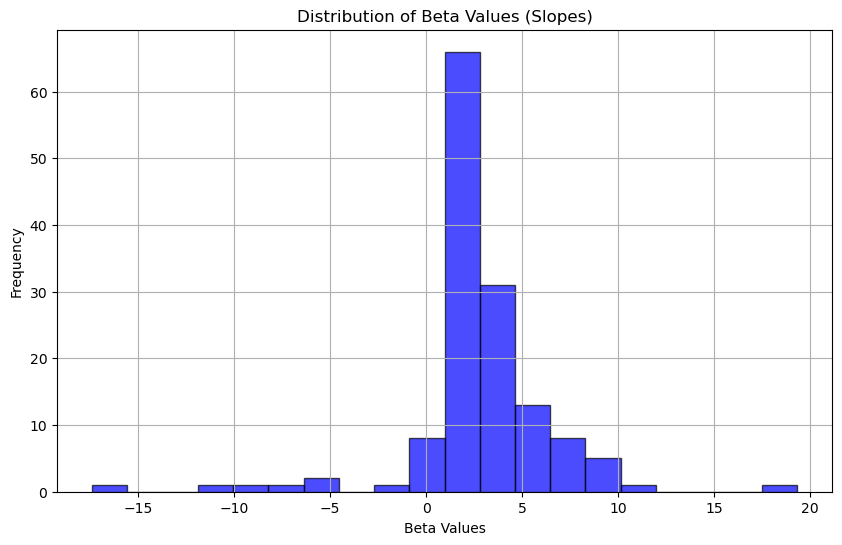

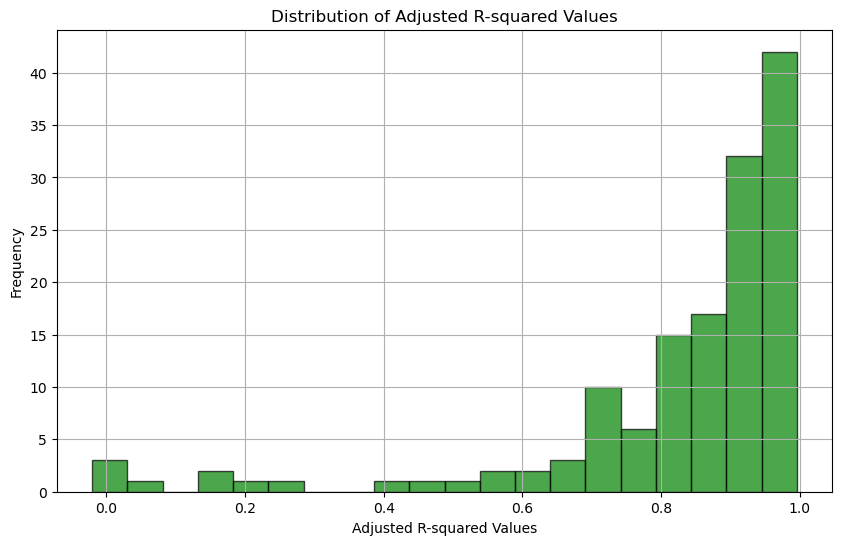

Summary of Beta Values (Slopes):
count    140.000000
mean       2.902827
std        3.702725
min      -17.397705
25%        1.699730
50%        2.527694
75%        4.287989
max       19.321169
dtype: float64

Summary of Adjusted R-squared Values:
count    140.000000
mean       0.827460
std        0.212639
min       -0.020357
25%        0.804614
50%        0.903294
75%        0.955783
max        0.995807
dtype: float64


In [56]:
# Distribution of betas and r^2 values for GDP with Population
scaling_analysis_by_entity(df, 'Population - Sex: all - Age: all - Variant: estimates', 'GDP (output, multiple price benchmarks)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


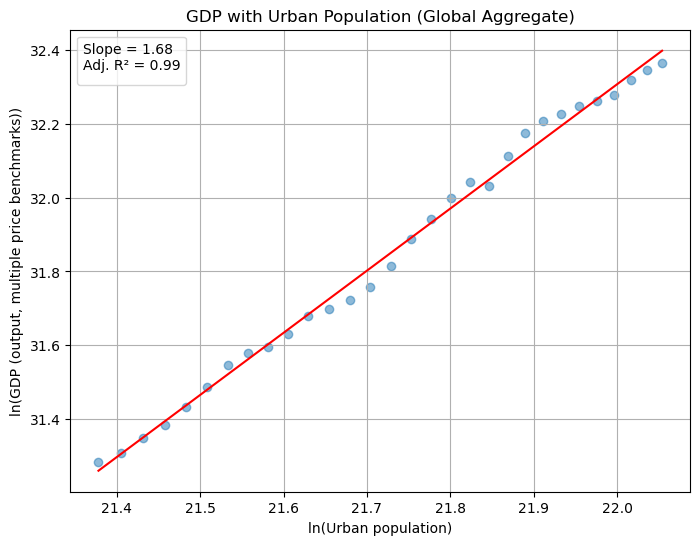

Slope (Scaling Exponent, β): 1.6842
Intercept (log(Y_0)): -4.7451
Normalization Constant (Y_0): 0.00869434716978643302
R-squared (Correlation Coefficient): 0.9943
Adjusted R-squared: 0.9941
P-value: 5.0697e-33
Standard Error of the Slope: 0.0240


In [57]:
scaling_analysis(world['Urban population'],
                 world['GDP (output, multiple price benchmarks)'],
                 x_label='ln(Urban population)',
                 y_label='ln(GDP (output, multiple price benchmarks))',
                 title='GDP with Urban Population (Global Aggregate)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


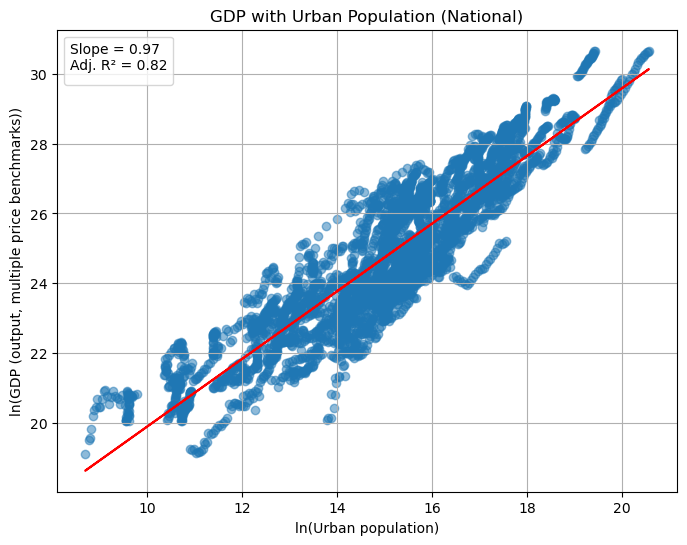

Slope (Scaling Exponent, β): 0.9679
Intercept (log(Y_0)): 10.2300
Normalization Constant (Y_0): 27723.07106749480590224266
R-squared (Correlation Coefficient): 0.8192
Adjusted R-squared: 0.8191
P-value: 0.0000e+00
Standard Error of the Slope: 0.0070


In [58]:
scaling_analysis(df['Urban population'],
                 df['GDP (output, multiple price benchmarks)'],
                 x_label='ln(Urban population)',
                 y_label='ln(GDP (output, multiple price benchmarks))',
                 title='GDP with Urban Population (National)')

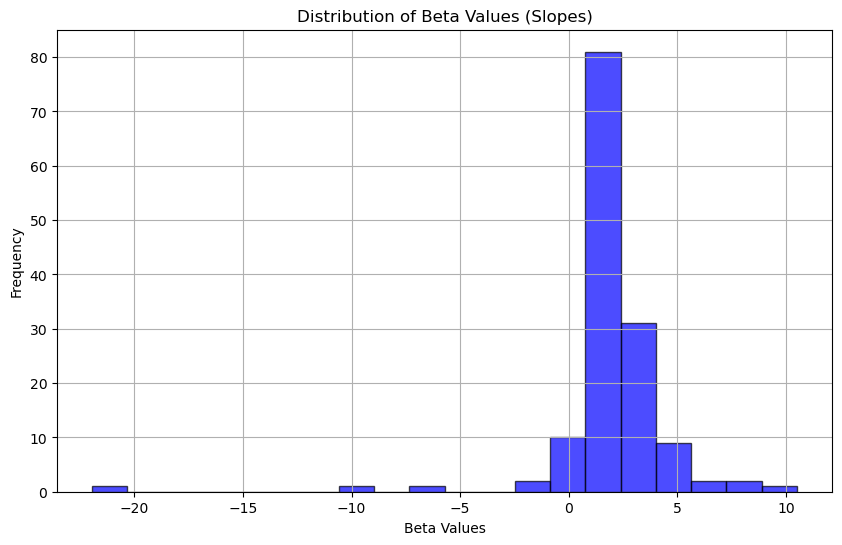

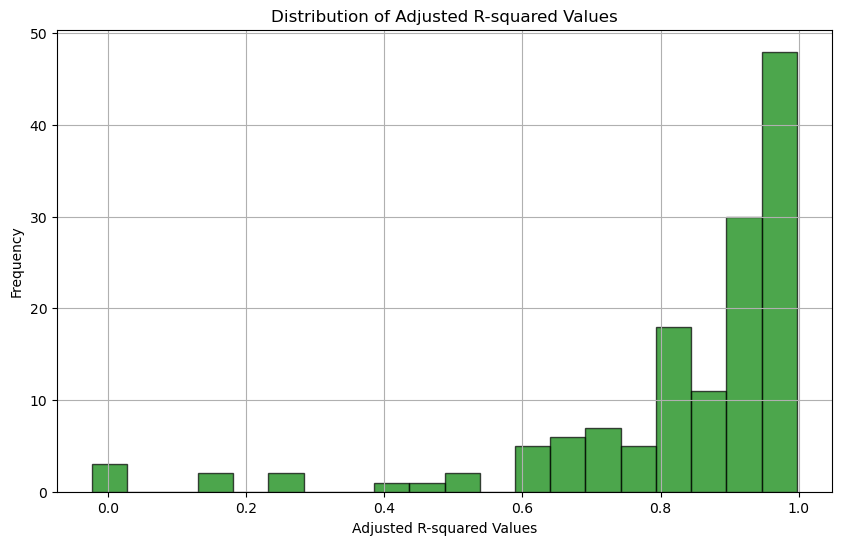

Summary of Beta Values (Slopes):
count    141.000000
mean       1.903042
std        2.890471
min      -21.939450
25%        1.194472
50%        1.748106
75%        2.820717
max       10.504974
dtype: float64

Summary of Adjusted R-squared Values:
count    141.000000
mean       0.832966
std        0.206624
min       -0.022372
25%        0.800918
50%        0.915876
75%        0.956613
max        0.997156
dtype: float64


In [324]:
# Distribution of betas and r^2 values for GDP with Urban Population
scaling_analysis_by_entity(df, 'Urban population', 'GDP (output, multiple price benchmarks)', )

### EDA Functions

In [ ]:
def log_log_plot(data, x_column, y_column, log_base='natural', title=None):
    """
    Create a log-log plot of two variables from a dataset, with optional base for logarithms.

    Parameters:
    data (DataFrame): The dataset containing the variables.
    x_column (str): The column name for the independent variable (X-axis).
    y_column (str): The column name for the dependent variable (Y-axis).
    log_base (str): 'natural' for natural log, 'base10' for log base 10. Default is 'natural'.
    title (str): The title of the plot. Default is None.
    
    Returns:
    None
    """
    # Select the logarithmic base
    if log_base == 'natural':
        log_func = np.log
        x_label = f'log({x_column})'
        y_label = f'log({y_column})'
    elif log_base == 'base10':
        log_func = np.log10
        x_label = f'log10({x_column})'
        y_label = f'log10({y_column})'
    else:
        raise ValueError("log_base should be either 'natural' or 'base10'")
    
    # Drop rows with non-positive values (log undefined for zero or negative values)
    filtered_data = data[[x_column, y_column]].copy()
    filtered_data = filtered_data[(filtered_data[x_column] > 0) & (filtered_data[y_column] > 0)]
    
    # Apply the log transformation
    log_x = log_func(filtered_data[x_column])
    log_y = log_func(filtered_data[y_column])
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=log_x, y=log_y)
    sns.regplot(x=log_x, y=log_y, scatter=False, color="red")  # Add a regression line
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title if title else f'Log-Log Plot of {y_column} vs {x_column}')
    plt.grid(True)
    plt.show()

In [ ]:
def plot_pop_stats(df, data_col):
    """
    Plots the time series statistics (mean, median, standard deviation, range) of a specified column over the 'Year'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    data_col (str): The name of the column in df from which statistics are calculated.

    Returns:
    BytesIO: The plot image saved in a BytesIO object.
    """
    # Calculate yearly statistics
    yearly_stats = df.groupby('Year')[data_col].agg(['mean', 'median', 'std', 'min', 'max'])

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # Plot Mean and Median
    yearly_stats[['mean', 'median']].plot(ax=ax[0], marker='o', title=f'Mean and Median of {data_col} Over Time')
    ax[0].set_ylabel(data_col)
    ax[0].grid(True)

    # Plot Range with Standard Deviation
    yearly_stats['range'] = yearly_stats['max'] - yearly_stats['min']
    yearly_stats[['range']].plot.area(ax=ax[1], title=f'Range and Standard Deviation of {data_col} Over Time', alpha=0.2, label='Range')
    yearly_stats['mean'].plot(ax=ax[1], color='red', marker='o', label='Mean')
    ax[1].fill_between(yearly_stats.index, yearly_stats['mean'] - yearly_stats['std'], yearly_stats['mean'] + yearly_stats['std'], color='gray', alpha=0.5, label='Standard Deviation')
    ax[1].set_ylabel(data_col)
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def pop_stats(df, data_col):
    """
    Plots the time series statistics (mean, median, standard deviation, range) of a specified column over the 'Year'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    data_col (str): The name of the column in df from which statistics are calculated.

    Returns:
    
    """
    # Calculate yearly statistics
    yearly_stats = df.groupby('Year')[data_col].agg(['mean', 'median', 'std', 'min', 'max'])
    
    # Ensure the index is a datetime object if 'Year' is not already the index
    yearly_stats.index = pd.to_datetime(yearly_stats.index, format='%Y')

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # Plot Mean and Median
    yearly_stats[['mean', 'median']].plot(ax=ax[0], marker='o', title=f'Mean and Median of {data_col} Over Time')
    ax[0].set_ylabel(data_col)
    ax[0].set_xlabel('Year')
    ax[0].grid(True)

    # Plot Range with Standard Deviation
    yearly_stats['range'] = yearly_stats['max'] - yearly_stats['min']
    yearly_stats[['range']].plot.area(ax=ax[1], title=f'Range and Standard Deviation of {data_col} Over Time', alpha=0.2, label='Range')
    yearly_stats['mean'].plot(ax=ax[1], color='red', marker='o', label='Mean')
    ax[1].fill_between(yearly_stats.index, yearly_stats['mean'] - yearly_stats['std'], yearly_stats['mean'] + yearly_stats['std'], color='gray', alpha=0.5, label='Standard Deviation')
    ax[1].set_ylabel(data_col)
    ax[1].set_xlabel('Year')
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    # plt.show()
    return plt


In [ ]:
from scipy.stats import pearsonr, spearmanr

def plot_scatter_with_trendline(df, x_var, y_var):
    # Scatterplot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_var, y=y_var, data=df)

    # Trendline
    z = np.polyfit(df[x_var], df[y_var], 1)
    p = np.poly1d(z)
    plt.plot(df[x_var], p(df[x_var]), color='red', label=f"Trendline (y={z[0]:.2f}x + {z[1]:.2f})")

    # Pearson and Spearman correlations
    pearson_corr, _ = pearsonr(df[x_var], df[y_var])
    spearman_corr, _ = spearmanr(df[x_var], df[y_var])

    # Adding correlation info to plot (bottom-right corner)
    plt.text(0.95, 0.05, f'Pearson: {pearson_corr:.2f}\nSpearman: {spearman_corr:.2f}',
             horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.5))

    # Labels and title
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f'{x_var} vs {y_var}')
    plt.legend()
    plt.show()

# Example usage:
# plot_scatter_with_trendline(df, 'GDP', 'Energy Consumption')


In [ ]:
def histogram(df, column):
    """
    Creates an interactive histogram chart of the distribution of a specified column,
    with a slider to control the displayed year.

    Parameters:
    df (pd.DataFrame): Dataframe containing the data.
    column (str): Name of the column to plot the histogram for.

    Returns:
    fig: Plotly figure object.
    """
    # Ensure the dataframe contains the required 'Year' column
    if 'Year' not in df.columns:
        raise ValueError("The dataframe must contain a 'Year' column.")
    
    # Ensure the specified column exists in the dataframe
    if column not in df.columns:
        raise ValueError(f"The column '{column}' is not in the dataframe.")

    # Sort dataframe by year to ensure correct animation order
    df = df.sort_values(by='Year')

    # Create an interactive histogram using Plotly Express
    fig = px.histogram(df, x=column, animation_frame='Year', nbins=50,
                       title=f"Histogram of {column} by Year",
                       labels={column: column, 'Year': 'Year'})

    # Update layout for better appearance and animation settings
    fig.update_layout(
        bargap=0.1,
        xaxis_title=column,
        yaxis_title='Count',
        title=f"Histogram of {column} by Year",
        width=1000,  # Set the width of the figure
        height=600,  # Set the height of the figure
        updatemenus=[{
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': True},
                                    'fromcurrent': True, 'mode': 'immediate'}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                      'mode': 'immediate'}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 20},
                'prefix': 'Year:',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 300, 'easing': 'cubic-in-out'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [
                {
                    'args': [
                        [year],
                        {'frame': {'duration': 300, 'redraw': True},
                         'mode': 'immediate'}
                    ],
                    'label': str(year),
                    'method': 'animate'
                }
                for year in sorted(df['Year'].unique())
            ]
        }]
    )

    # Show the figure
    # fig.show()

    return fig

In [468]:
import plotly.express as px
import plotly.graph_objects as go

def stacked_bar(df, value_column, top_n=5):
    """
    Creates a stacked bar chart showing the top N entity values over time,
    with all other entities combined into an 'Other' segment.

    Parameters:
    df (pd.DataFrame): Dataframe containing the data with 'Year' and 'Entity' columns.
    value_column (str): Name of the column to plot the stacked bar chart for.
    top_n (int): Number of top entities to include in the chart.

    Returns:
    fig: Plotly figure object.
    """
    # Ensure the dataframe contains the required 'Year' and 'Entity' columns
    if 'Year' not in df.columns or 'Entity' not in df.columns:
        raise ValueError("The dataframe must contain 'Year' and 'Entity' columns.")
    
    # Ensure the specified column exists in the dataframe
    if value_column not in df.columns:
        raise ValueError(f"The column '{value_column}' is not in the dataframe.")

    # Initialize a dictionary to store data for the plot
    plot_data_dict = {}

    # Group data by year
    years = df['Year'].unique()
    for year in years:
        df_year = df[df['Year'] == year]

        # Sort the entities by the value column in descending order and get the top N entities
        top_entities = df_year.nlargest(top_n, value_column)

        # Calculate the sum for the "Other" segment
        others_sum = df_year[~df_year['Entity'].isin(top_entities['Entity'])][value_column].sum()

        # Add the top N entities and the "Other" segment to the dictionary
        for _, row in top_entities.iterrows():
            if row['Entity'] not in plot_data_dict:
                plot_data_dict[row['Entity']] = {}
            plot_data_dict[row['Entity']][year] = row[value_column]
        
        if 'Other' not in plot_data_dict:
            plot_data_dict['Other'] = {}
        plot_data_dict['Other'][year] = others_sum

    # Convert the dictionary to a DataFrame
    plot_data = pd.DataFrame(plot_data_dict).fillna(0)

    # Create a Plotly figure
    fig = go.Figure()

    # Add traces for each entity
    for entity in plot_data.columns:
        fig.add_trace(go.Bar(
            x=plot_data.index,
            y=plot_data[entity],
            name=entity
        ))

    # Update layout for the stacked bar chart
    fig.update_layout(
        barmode='stack',
        title=f'Stacked Bar Chart: Top {top_n} {value_column} Contribution by Entity Over Time',
        xaxis_title='Year',
        yaxis_title=value_column,
        legend_title='Entity',
        height=600,
        width=1000
    )

    return fig

# Example usage:
# df = pd.read_csv('your_data.csv')
# fig = stacked_bar_chart_top_entities(df, 'Population', top_n=5)
# fig.show()


##### 'GDP (output, multiple price benchmarks)'

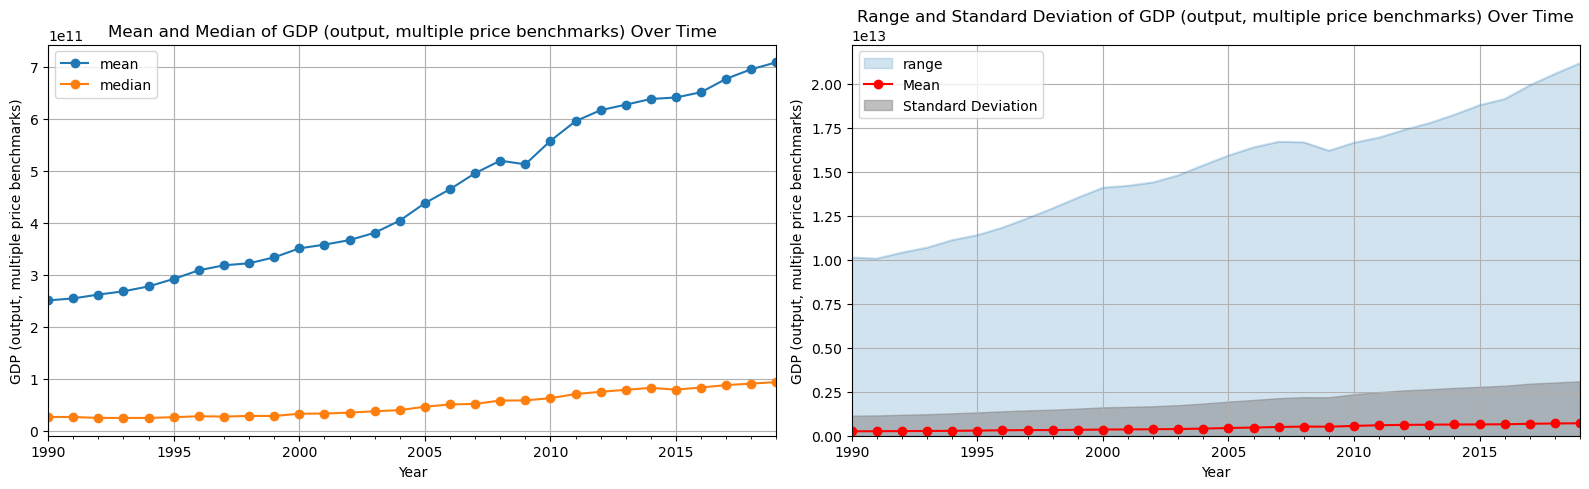

In [79]:
# Population stats
pop_stats(df, 'GDP (output, multiple price benchmarks)').show()

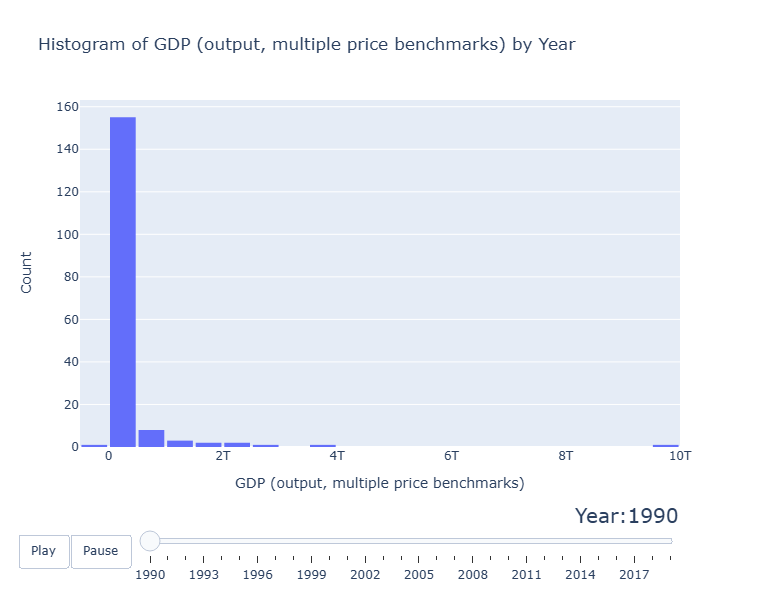

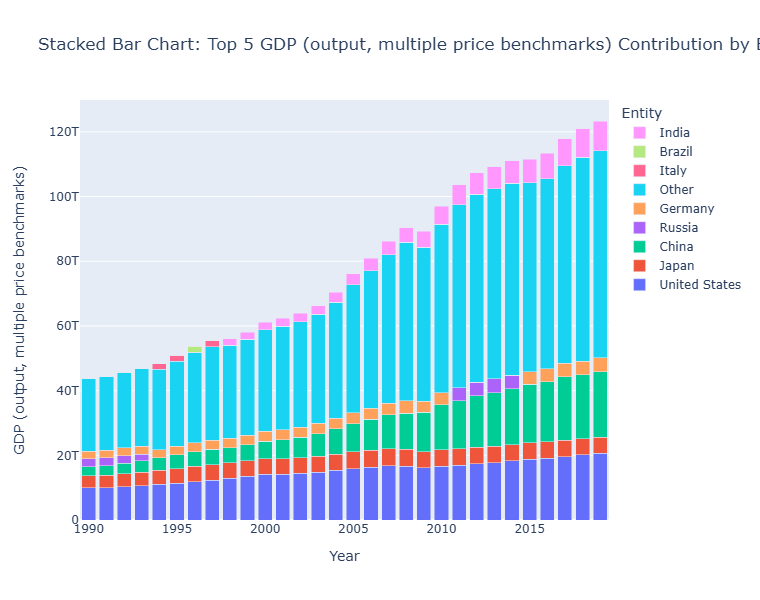

In [80]:
# Distribution and proportions
histogram(df, 'GDP (output, multiple price benchmarks)').show()
stacked_bar(df, 'GDP (output, multiple price benchmarks)', top_n=5).show()

In [81]:
df.columns

Index(['Entity', 'Year', 'Population',
       'Population of children under the age of 1',
       'Population of children under the age of 5',
       'Population of children under the age of 15',
       'Population under the age of 25', 'Population aged 15 to 64 years',
       'Population older than 15 years', 'Population older than 18 years',
       'Population at age 1', 'Population aged 1 to 4 years',
       'Population aged 5 to 9 years', 'Population aged 10 to 14 years',
       'Population aged 15 to 19 years', 'Population aged 20 to 29 years',
       'Population aged 30 to 39 years', 'Population aged 40 to 49 years',
       'Population aged 50 to 59 years', 'Population aged 60 to 69 years',
       'Population aged 70 to 79 years', 'Population aged 80 to 89 years',
       'Population aged 90 to 99 years', 'Population older than 100 years',
       'Code', 'Period life expectancy at birth - Sex: all - Age: 0',
       'GDP (output, multiple price benchmarks)',
       'Primary energy 

In [469]:
import plotly.express as px
import plotly.graph_objects as go

def scatterplot(df, x_column, y_column):
    """
    Creates an interactive scatter plot chart of the specified columns,
    with a slider to control the displayed year.

    Parameters:
    df (pd.DataFrame): Dataframe containing the data.
    x_column (str): Name of the column to plot on the x-axis.
    y_column (str): Name of the column to plot on the y-axis.

    Returns:
    fig: Plotly figure object.
    """
    # Ensure the dataframe contains the required 'Year' column
    if 'Year' not in df.columns:
        raise ValueError("The dataframe must contain a 'Year' column.")
    
    # Ensure the specified columns exist in the dataframe
    if x_column not in df.columns or y_column not in df.columns:
        raise ValueError(f"Both columns '{x_column}' and '{y_column}' must be in the dataframe.")

    # Assume the first column is the entity column
    entity_column = df.columns[0]

    # Sort dataframe by year to ensure correct animation order
    df = df.sort_values(by=['Year', 'Entity'])

    # Create the initial scatter plot
    fig = px.scatter(df[df['Year'] == df['Year'].min()], x=x_column, y=y_column,
                     title=f"Scatter Plot of {x_column} vs {y_column} by Year",
                     labels={x_column: x_column, y_column: y_column},
                     hover_data={entity_column: True})

    # Set the x and y axis ranges to remain constant
    x_range = [df[x_column].min(), df[x_column].max()]
    y_range = [df[y_column].min(), df[y_column].max()]

    fig.update_layout(
        xaxis=dict(range=x_range),
        yaxis=dict(range=y_range),
        width=1000,  # Set the width of the figure
        height=600,  # Set the height of the figure
        updatemenus=[{
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 1000, 'redraw': True},
                                    'fromcurrent': True, 'mode': 'immediate'}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                      'mode': 'immediate'}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 20},
                'prefix': 'Year:',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 1000, 'easing': 'linear'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [
                {
                    'args': [
                        [year],
                        {'frame': {'duration': 1000, 'redraw': True},
                         'mode': 'immediate'}
                    ],
                    'label': str(year),
                    'method': 'animate'
                }
                for year in sorted(df['Year'].unique())
            ]
        }]
    )

    # Create a frame for each year
    frames = []
    for year in df['Year'].unique():
        filtered_df = df[df['Year'] == year]
        frames.append(go.Frame(
            data=[go.Scatter(
                x=filtered_df[x_column], 
                y=filtered_df[y_column],
                mode='markers',
                marker=dict(size=6),
                text=filtered_df[entity_column],
                hoverinfo='text')],
            name=str(year)
        ))

    fig.frames = frames

    return fig


In [470]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_interactive(data):
    """
    Interactive plot for a specified variable for a given entity over time.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing the data.
    """
    # Create dropdown widgets for entity and variable
    entity_widget = widgets.Dropdown(
        options=data['Entity'].unique(),
        description='Entity:',
        disabled=False,
    )
    
    variable_widget = widgets.Dropdown(
        options=[col for col in data.columns if col not in ['Entity', 'Year']],
        description='Variable:',
        disabled=False,
    )
    
    def plot_data(entity, variable):
        # Filter data for the specified entity
        entity_data = data[data['Entity'] == entity]
        
        # Check if the specified variable exists in the dataframe
        if variable not in entity_data.columns:
            print(f"Variable '{variable}' not found in the dataset.")
            return
        
        # Plot the data
        plt.figure(figsize=(10, 6))
        plt.plot(entity_data['Year'], entity_data[variable], marker='o')
        plt.title(f'{variable} over time for {entity}')
        plt.xlabel('Year')
        plt.ylabel(variable)
        plt.grid(True)
        plt.show()
    
    # Use the interactive function to link the widgets to the plot
    interactive_plot = widgets.interactive(plot_data, entity=entity_widget, variable=variable_widget)
    display(interactive_plot)

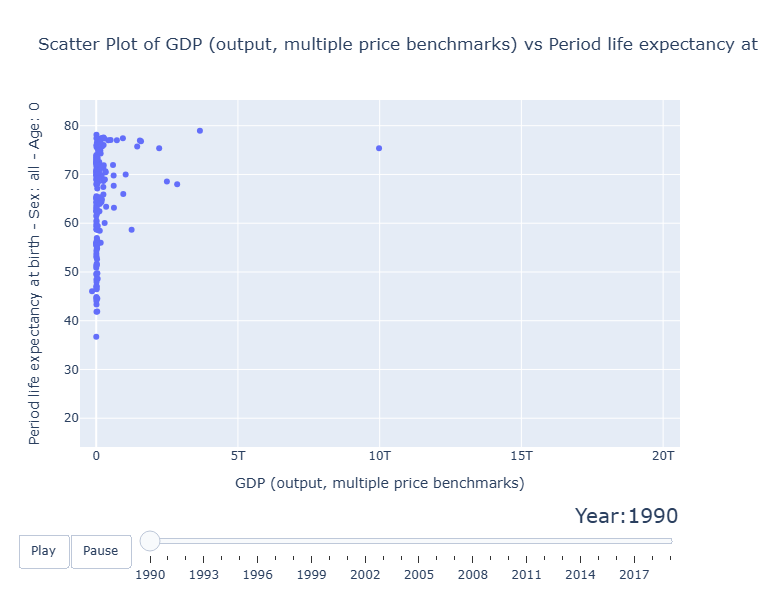

In [86]:
scatterplot(df, "GDP (output, multiple price benchmarks)", "Period life expectancy at birth - Sex: all - Age: 0")

#### Multivariate Analysis
- Include Other Variables: Investigate how other variables (e.g., population density, urban population percentage, life expectancy) influence the GDP-energy consumption relationship.
- Multiple Regression: Perform multiple regression analysis to assess the impact of multiple factors on GDP and energy consumption.

In [94]:
import plotly.express as px
import plotly.graph_objects as go

def scatterplot_3d(df, x_column, y_column, z_column):
    """
    Creates an interactive 3D scatter plot chart of the specified columns,
    with a slider to control the displayed year.

    Parameters:
    df (pd.DataFrame): Dataframe containing the data.
    x_column (str): Name of the column to plot on the x-axis.
    y_column (str): Name of the column to plot on the y-axis.
    z_column (str): Name of the column to plot on the z-axis.

    Returns:
    fig: Plotly figure object.
    """
    # Ensure the dataframe contains the required 'Year' column
    if 'Year' not in df.columns:
        raise ValueError("The dataframe must contain a 'Year' column.")
    
    # Ensure the specified columns exist in the dataframe
    if x_column not in df.columns or y_column not in df.columns or z_column not in df.columns:
        raise ValueError(f"Columns '{x_column}', '{y_column}', and '{z_column}' must be in the dataframe.")

    # Assume the first column is the entity column
    entity_column = df.columns[0]

    # Sort dataframe by year to ensure correct animation order
    df = df.sort_values(by=['Year', 'Entity'])

    # Create the initial scatter plot
    fig = px.scatter_3d(df[df['Year'] == df['Year'].min()], x=x_column, y=y_column, z=z_column,
                        title=f"3D Scatter Plot of {x_column} vs {y_column} vs {z_column} by Year",
                        labels={x_column: x_column, y_column: y_column, z_column: z_column},
                        hover_data={entity_column: True})

    # Set the axis ranges to remain constant
    x_range = [df[x_column].min(), df[x_column].max()]
    y_range = [df[y_column].min(), df[y_column].max()]
    z_range = [df[z_column].min(), df[z_column].max()]

    fig.update_layout(
        scene=dict(
            xaxis=dict(range=x_range),
            yaxis=dict(range=y_range),
            zaxis=dict(range=z_range),
        ),
        width=1000,  # Set the width of the figure
        height=600,  # Set the height of the figure
        updatemenus=[{
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 1000, 'redraw': True},
                                    'fromcurrent': True, 'mode': 'immediate'}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': True},
                                      'mode': 'immediate'}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }],
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 20},
                'prefix': 'Year:',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 1000, 'easing': 'linear'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [
                {
                    'args': [
                        [year],
                        {'frame': {'duration': 1000, 'redraw': True},
                         'mode': 'immediate'}
                    ],
                    'label': str(year),
                    'method': 'animate'
                }
                for year in sorted(df['Year'].unique())
            ]
        }]
    )

    # Create a frame for each year
    frames = []
    for year in df['Year'].unique():
        filtered_df = df[df['Year'] == year]
        frames.append(go.Frame(
            data=[go.Scatter3d(
                x=filtered_df[x_column], 
                y=filtered_df[y_column],
                z=filtered_df[z_column],
                mode='markers',
                marker=dict(size=4),
                text=filtered_df[entity_column],
                hoverinfo='text')],
            name=str(year)
        ))

    fig.frames = frames

    return fig


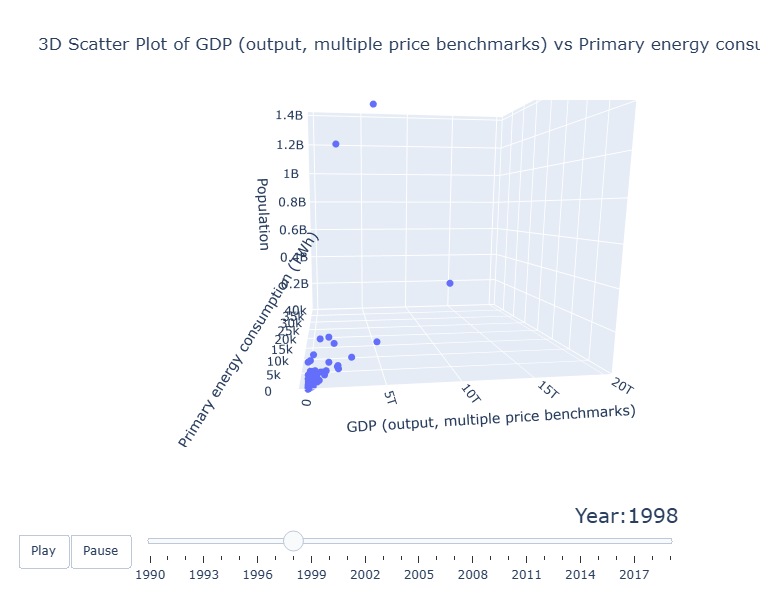

In [95]:
scatterplot_3d(df, 'GDP (output, multiple price benchmarks)', 'Primary energy consumption (TWh)', 'Population')

In [102]:
from scipy.stats import spearmanr, kendalltau

def corr_dist(data, var1, var2, method='p'):
    """
    Visualize the distribution of correlation coefficients across entities for a pair of variables.
    
    Parameters:
    data (DataFrame): The dataset containing the variables.
    var1 (str): The name of the first variable.
    var2 (str): The name of the second variable.
    method (str): The correlation method ('p' for Pearson, 's' for Spearman's rank, 'k' for Kendall's tau).
    
    Returns:
    None: Displays a histogram of the correlation coefficients.
    """
    # Define the correlation function based on the method parameter
    if method == 'p':
        corr_func = lambda x: x[var1].corr(x[var2], method='pearson')
        title = f"Pearson's Correlation"
    elif method == 's':
        corr_func = lambda x: spearmanr(x[var1], x[var2])[0]
        title = f"Spearman's Rank Correlation"
    elif method == 'k':
        corr_func = lambda x: kendalltau(x[var1], x[var2])[0]
        title = f"Kendall's Tau Correlation"
    else:
        raise ValueError("Invalid method. Use 'p' for Pearson, 's' for Spearman, or 'k' for Kendall.")

    # Group by 'Entity' and calculate correlation for each entity
    correlations = data.groupby('Entity').apply(corr_func)

    # Define bin edges and tick marks
    x_settings = np.arange(-1, 1.1, 0.2)
    
    # Plot the distribution of correlation coefficients
    plt.figure(figsize=(10, 6))
    sns.histplot(correlations, bins=x_settings, kde=False)
    plt.title(f'Distribution of {title} between {var1} and {var2} Across Entities')
    plt.xlabel(f'{title} Coefficient')
    plt.ylabel('Frequency')
    plt.xlim(-1, 1)  # Set x-axis limits
    plt.xticks(x_settings)  # Set regular increments on x-axis
    plt.grid(True)
    plt.show()

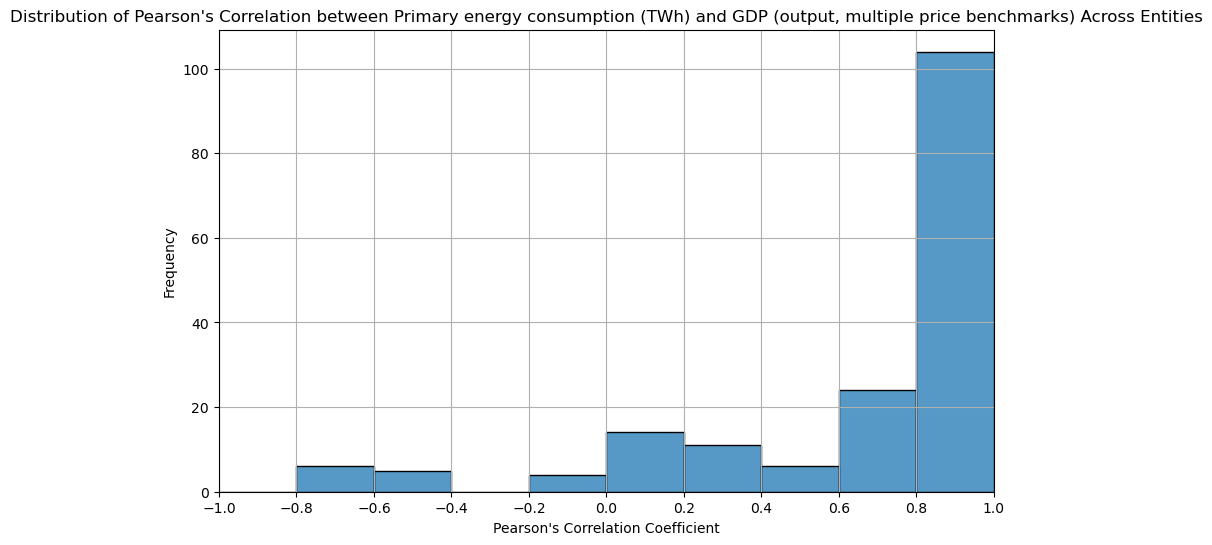

In [103]:
corr_dist(df, 'Primary energy consumption (TWh)', 'GDP (output, multiple price benchmarks)', method='p')

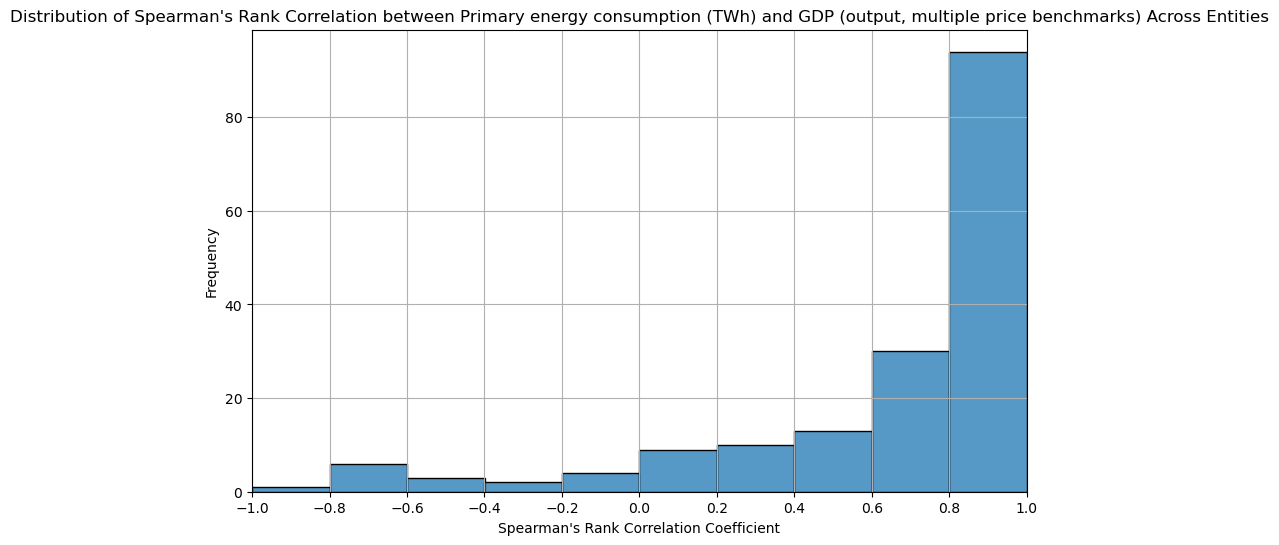

In [104]:
corr_dist(df, 'Primary energy consumption (TWh)', 'GDP (output, multiple price benchmarks)', method='s')

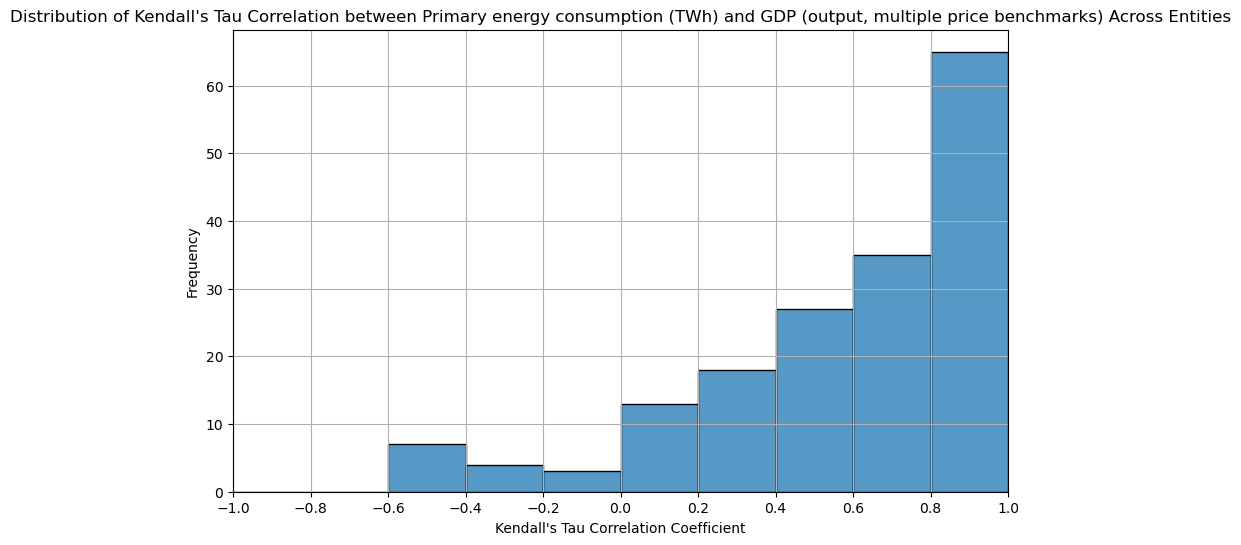

In [105]:
corr_dist(df, 'Primary energy consumption (TWh)', 'GDP (output, multiple price benchmarks)', method='k')

In [106]:
def calculate_and_plot_correlation_matrix(data, variables, method='pearson'):
    """
    Calculate the correlation matrix for a list of selected variables and plot a heatmap.

    Parameters:
    data (DataFrame): The dataset containing the variables.
    variables (list): A list of variable names for which to calculate the correlation matrix.
    method (str): The correlation method ('pearson', 'spearman', or 'kendall').

    Returns:
    None: Displays a heatmap of the correlation matrix.
    """
    # Ensure the method is valid
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Invalid method. Use 'pearson', 'spearman', or 'kendall'.")

    # Calculate the correlation matrix
    correlation_matrix = data[variables].corr(method=method)
    
    # Plot the heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5, vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix Heatmap ({method.capitalize()})')
    plt.show()

# Example usage (uncomment and replace 'variables' with a list of actual column names):
# calculate_and_plot_correlation_matrix(data, variables=['var1', 'var2', 'var3'], method='spearman')



C:\Users\dunnn2\AppData\Local\Temp\ipykernel_29240\4271786634.py:18: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



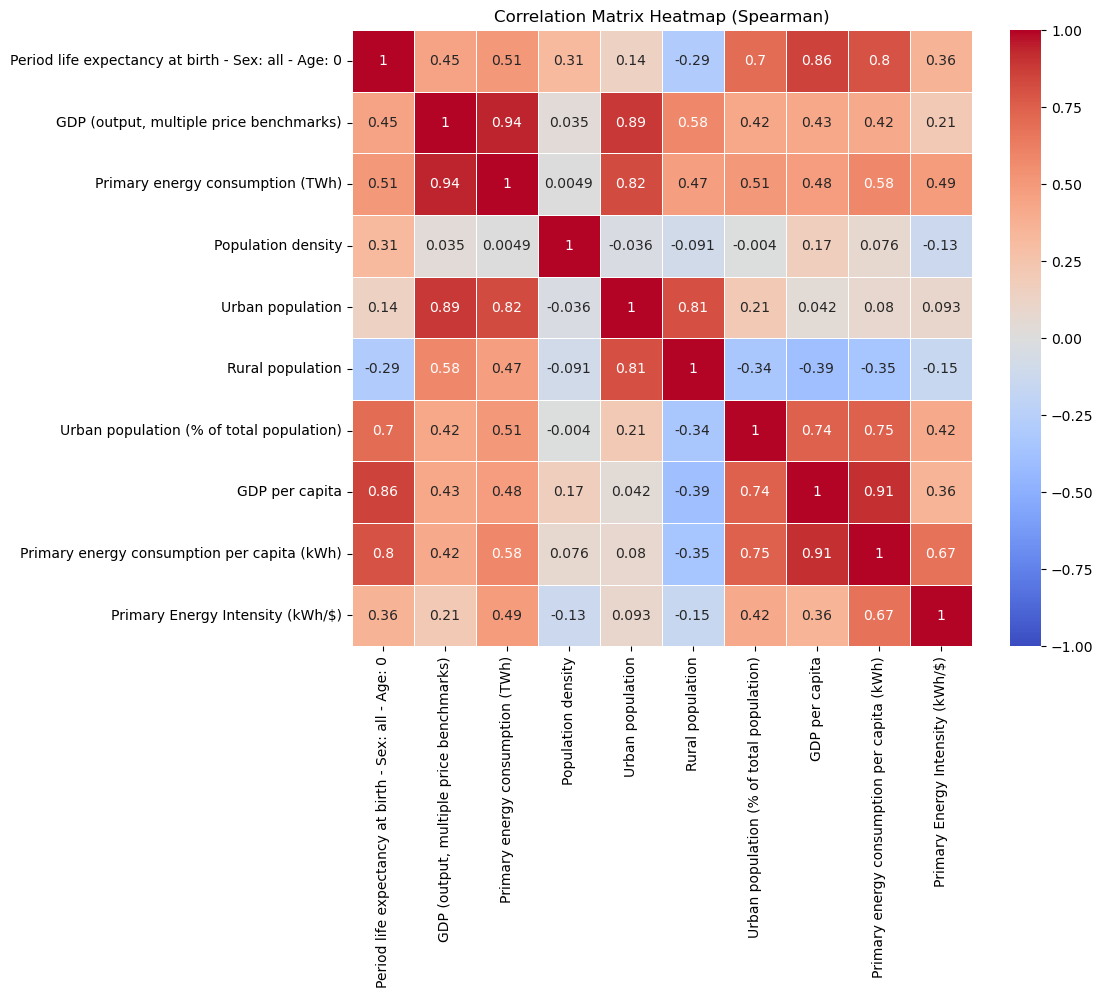

In [107]:
calculate_and_plot_correlation_matrix(df, variables=df.columns[25:], method='spearman')

In [108]:
df.columns

Index(['Entity', 'Year', 'Population',
       'Population of children under the age of 1',
       'Population of children under the age of 5',
       'Population of children under the age of 15',
       'Population under the age of 25', 'Population aged 15 to 64 years',
       'Population older than 15 years', 'Population older than 18 years',
       'Population at age 1', 'Population aged 1 to 4 years',
       'Population aged 5 to 9 years', 'Population aged 10 to 14 years',
       'Population aged 15 to 19 years', 'Population aged 20 to 29 years',
       'Population aged 30 to 39 years', 'Population aged 40 to 49 years',
       'Population aged 50 to 59 years', 'Population aged 60 to 69 years',
       'Population aged 70 to 79 years', 'Population aged 80 to 89 years',
       'Population aged 90 to 99 years', 'Population older than 100 years',
       'Code', 'Period life expectancy at birth - Sex: all - Age: 0',
       'GDP (output, multiple price benchmarks)',
       'Primary energy 

C:\Users\dunnn2\AppData\Local\Temp\ipykernel_29240\4271786634.py:18: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



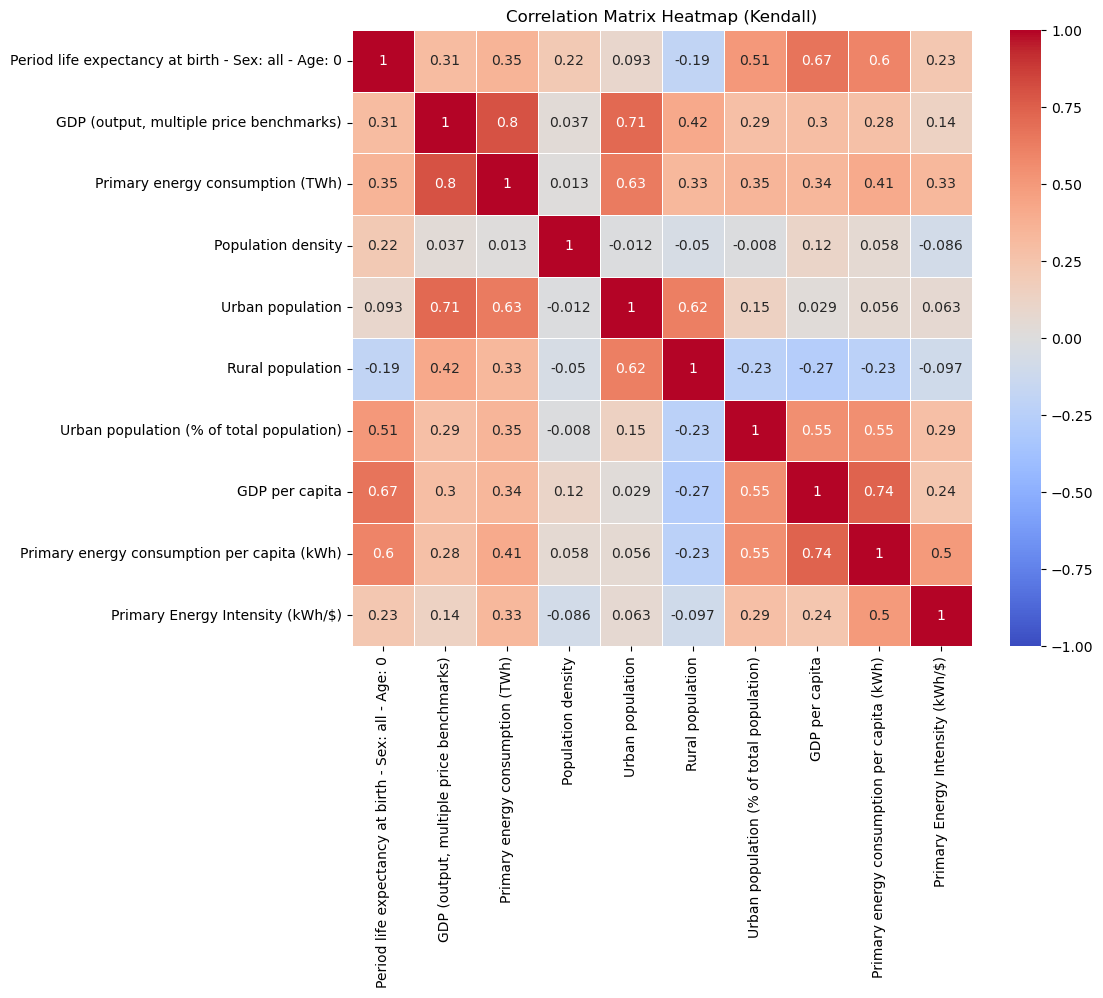

In [109]:
calculate_and_plot_correlation_matrix(df, variables=df.columns[25:], method='kendall')

C:\Users\dunnn2\AppData\Local\Temp\ipykernel_29240\4271786634.py:18: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



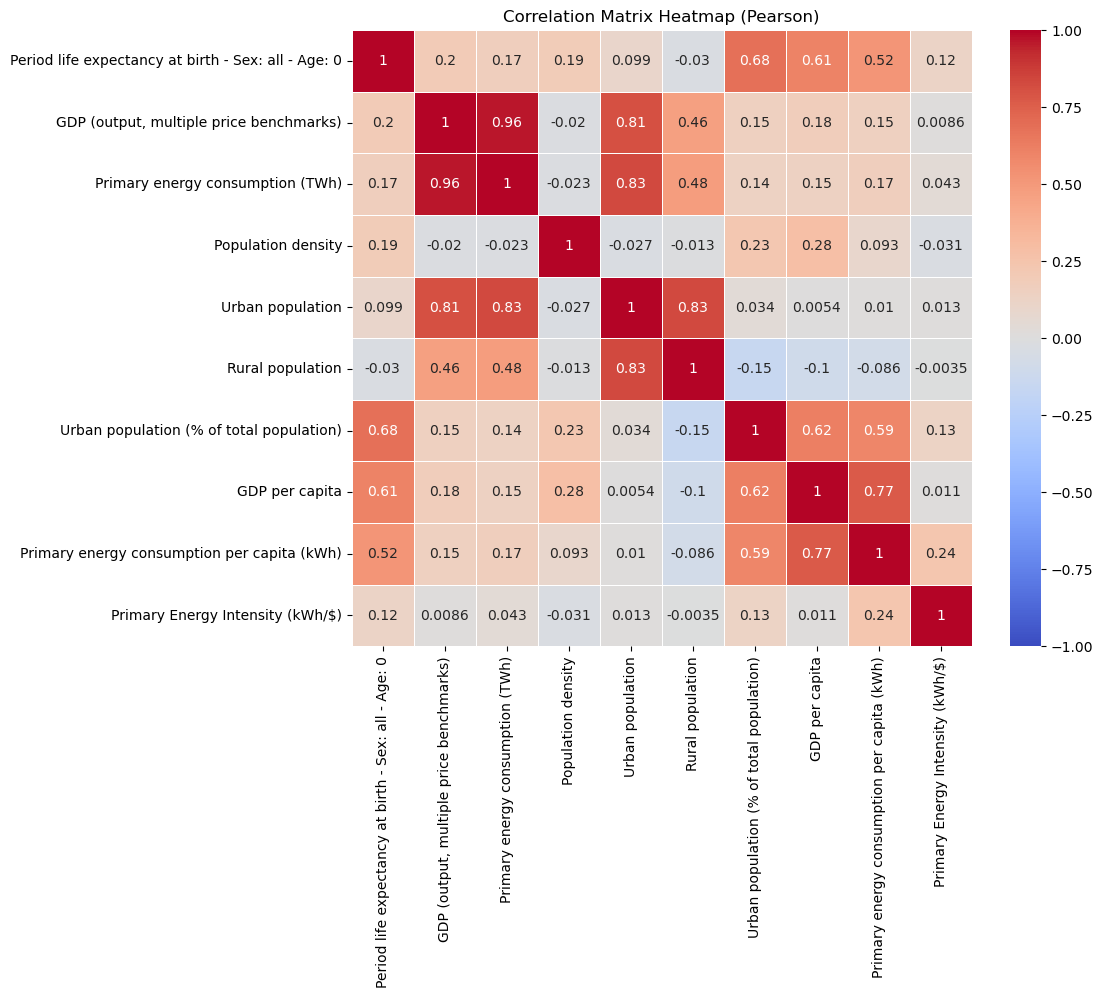

In [110]:
calculate_and_plot_correlation_matrix(df, variables=df.columns[25:], method='pearson')